In [36]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [37]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [38]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [39]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

from scipy.optimize import curve_fit
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

    print(alpha, alpha_err)

In [40]:
Set_Mapping([2,3,5,4,1])
nqubit=2
C=20
results_d2=np.zeros((C,2**(2*nqubit)))
results_d4=np.zeros((C,2**(2*nqubit)))
results_d8=np.zeros((C,2**(2*nqubit)))

# file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=2.txt", 'r')
file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/02062024 EAB_FT_01+10_23541/d=2.txt")
Lines= file.readlines()
c_d2=[]
count = 0
for line in Lines:
    c_d2.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/02062024 EAB_FT_01+10_23541/d=4.txt", 'r')
Lines= file.readlines()
c_d4=[]
count = 0
for line in Lines:
    c_d4.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/02062024 EAB_FT_01+10_23541/d=8.txt", 'r')
Lines= file.readlines()
c_d8=[]
count = 0
for line in Lines:
    c_d8.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/02062024 EAB_FT_01+10_23541/d=16.txt", 'r')
Lines= file.readlines()
c_d16=[]
count = 0
for line in Lines:
    c_d16.append(line)
    count += 1
print (count)
count=0


file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/02062024 EAB_FT_01+10_23541/d=32.txt", 'r')
Lines= file.readlines()
c_d32=[]
count = 0
for line in Lines:
    c_d32.append(line)
    count += 1
print (count)
count=0



20
20
20
20
20


In [41]:
filenames_d2=[]
filenames_d4=[]
filenames_d8=[]
filenames_d16=[]
filenames_d32=[]
filenames_d2_0703=[]
filenames_d4_0703=[]
filenames_d8_0703=[]
filenames_d2_rerun=[]
filenames=[]

paf_data_d2="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/half wait time 02062024/300us/2024-02-06 UMD__d=2 300us wait/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2.append(filenames[i])
            break
print (filenames_d2)



# paf_data_d4="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=4/"
# L1=[]
# filenames=[]
# line_Idx="000"
# line_num=""
# p=0 #position indicator

# #------------------------------------------read in raw data-------------------------------
# for f in os.listdir(paf_data_d4):
#     if (f.find("Line")!=-1):
#         n=f.find("_")
#         line_Idx=f[n+6:n+9]
#         for i in range(3):
#             if line_Idx[i]=="0":
#                 p+=1
#             else:
#                 line_num=line_Idx[p:3]
#                 p=0
#                 break
#         L1.append(int(line_num))
#         filenames.append(f)
#     else:
#         print (f) #print out non datafiles just for debugging 
#         continue
# for Idx in range (len(filenames)):
#     for i in range (len(filenames)):
#         if L1[i]==Idx+1:
#             filenames_d4.append(filenames[i])
#             break
# print (filenames_d4)





paf_data_d8="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/half wait time 02062024/300us/2024-02-06 UMD__d=8 300us wait/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d8 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d8.append(filenames[i])
            break
print (filenames_d8)



# paf_data_d16="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=16/"
# L1=[]
# filenames=[]
# line_Idx="000"
# line_num=""
# p=0 #position indicator

# #------------------------------------------read in raw data-------------------------------
# for f in os.listdir(paf_data_d16 ):
#     if (f.find("Line")!=-1):
#         n=f.find("_")
#         line_Idx=f[n+6:n+9]
#         for i in range(3):
#             if line_Idx[i]=="0":
#                 p+=1
#             else:
#                 line_num=line_Idx[p:3]
#                 p=0
#                 break
#         L1.append(int(line_num))
#         filenames.append(f)
#     else:
#         print (f) #print out non datafiles just for debugging 
#         continue
# for Idx in range (len(filenames)):
#     for i in range (len(filenames)):
#         if L1[i]==Idx+1:
#             filenames_d16.append(filenames[i])
#             break
# print (filenames_d16)



paf_data_d32="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/half wait time 02062024/300us/2024-02-06 UMD__d=32 300us wait/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d32 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d32.append(filenames[i])
            break
print (filenames_d32)



['2024-02-06-181743_Line_001.txt', '2024-02-06-181808_Line_002.txt', '2024-02-06-181833_Line_003.txt', '2024-02-06-182256_Line_004.txt', '2024-02-06-182320_Line_005.txt', '2024-02-06-182425_Line_006.txt', '2024-02-06-182449_Line_007.txt', '2024-02-06-182515_Line_008.txt', '2024-02-06-182539_Line_009.txt', '2024-02-06-182603_Line_010.txt', '2024-02-06-210114_Line_011.txt', '2024-02-06-210139_Line_012.txt', '2024-02-06-210202_Line_013.txt', '2024-02-06-210226_Line_014.txt', '2024-02-06-210250_Line_015.txt', '2024-02-06-210355_Line_016.txt', '2024-02-06-210419_Line_017.txt', '2024-02-06-210444_Line_018.txt', '2024-02-06-210508_Line_019.txt', '2024-02-06-210532_Line_020.txt']
['2024-02-06-190742_Line_001.txt', '2024-02-06-190818_Line_002.txt', '2024-02-06-190855_Line_003.txt', '2024-02-06-190931_Line_004.txt', '2024-02-06-191009_Line_005.txt', '2024-02-06-191125_Line_006.txt', '2024-02-06-191201_Line_007.txt', '2024-02-06-191239_Line_008.txt', '2024-02-06-191316_Line_009.txt', '2024-02-06-

In [42]:
a=Quantum_State(5)
a_s=Quantum_State(5)
b_c=Quantum_Circuit(5,"qc")

# a_0703=Quantum_State(5)
# a_rerun=Quantum_State(5)

# spam1=SPAM_Operator(5)
# spam1.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM1/SPAM1.csv")

# spam2=SPAM_Operator(5)
# spam2.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM2/SPAM2.csv")


['2024-02-06-181743_Line_001.txt', '2024-02-06-181808_Line_002.txt', '2024-02-06-181833_Line_003.txt', '2024-02-06-182256_Line_004.txt', '2024-02-06-182320_Line_005.txt', '2024-02-06-182425_Line_006.txt', '2024-02-06-182449_Line_007.txt', '2024-02-06-182515_Line_008.txt', '2024-02-06-182539_Line_009.txt', '2024-02-06-182603_Line_010.txt', '2024-02-06-210114_Line_011.txt', '2024-02-06-210139_Line_012.txt', '2024-02-06-210202_Line_013.txt', '2024-02-06-210226_Line_014.txt', '2024-02-06-210250_Line_015.txt', '2024-02-06-210355_Line_016.txt', '2024-02-06-210419_Line_017.txt', '2024-02-06-210444_Line_018.txt', '2024-02-06-210508_Line_019.txt', '2024-02-06-210532_Line_020.txt']
counts: [37, 1597, 2, 24, 21, 224, 0, 4, 2, 45, 0, 27, 0, 14, 0, 3]
counts_ibm_mapping_dic: {'0000': 37, '1000': 1597, '0100': 2, '1100': 24, '0010': 21, '1010': 224, '0110': 0, '1110': 4, '0001': 2, '1001': 45, '0101': 0, '1101': 27, '0011': 0, '1011': 14, '0111': 0, '1111': 3}


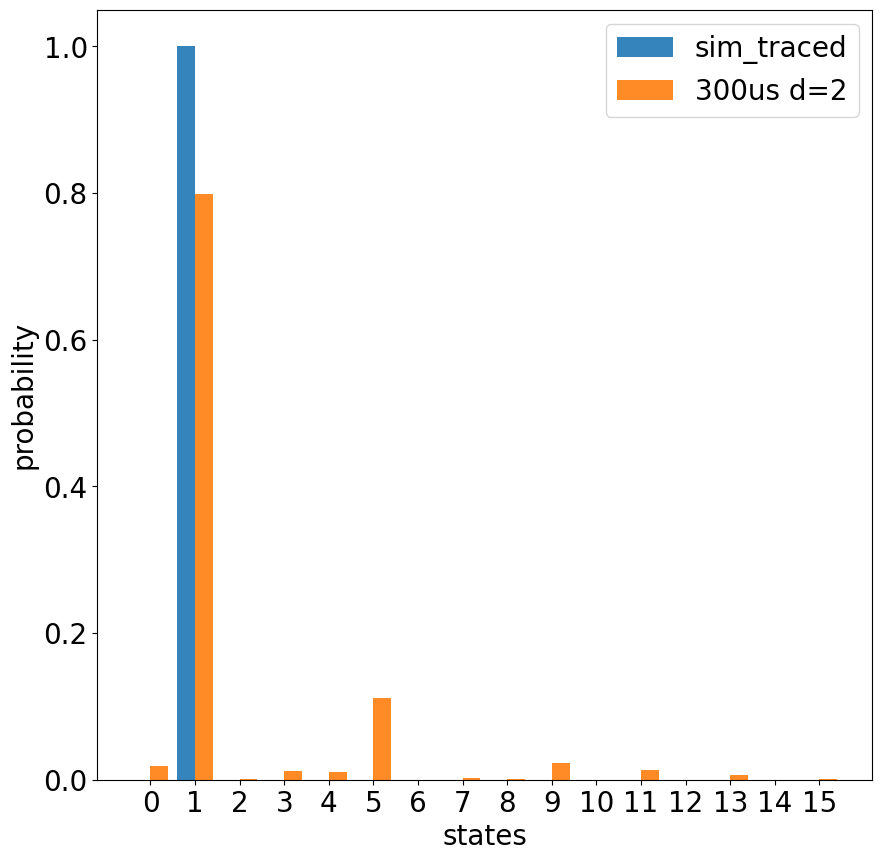

counts: [0, 14, 3, 143, 1, 0, 1, 20, 2, 40, 28, 1603, 0, 0, 24, 121]
counts_ibm_mapping_dic: {'0000': 0, '1000': 14, '0100': 3, '1100': 143, '0010': 1, '1010': 0, '0110': 1, '1110': 20, '0001': 2, '1001': 40, '0101': 28, '1101': 1603, '0011': 0, '1011': 0, '0111': 24, '1111': 121}


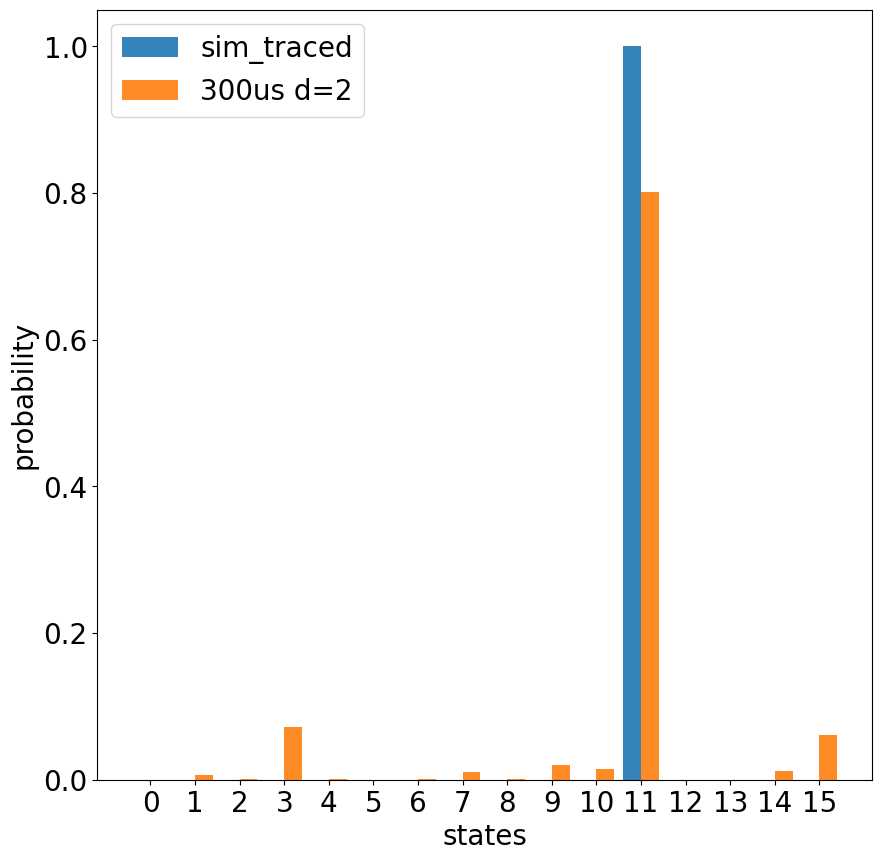

counts: [3, 3, 2, 11, 1, 55, 4, 115, 0, 2, 18, 118, 4, 32, 29, 1603]
counts_ibm_mapping_dic: {'0000': 3, '1000': 3, '0100': 2, '1100': 11, '0010': 1, '1010': 55, '0110': 4, '1110': 115, '0001': 0, '1001': 2, '0101': 18, '1101': 118, '0011': 4, '1011': 32, '0111': 29, '1111': 1603}


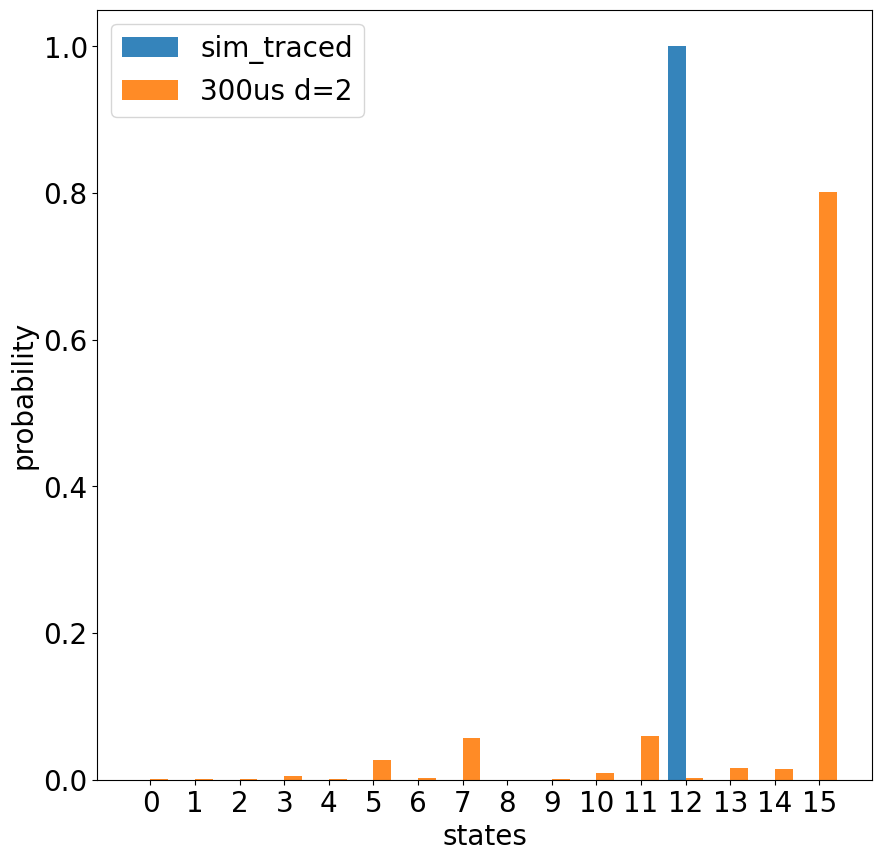

counts: [7, 2, 3, 0, 45, 0, 11, 0, 300, 19, 10, 1, 1548, 32, 20, 2]
counts_ibm_mapping_dic: {'0000': 7, '1000': 2, '0100': 3, '1100': 0, '0010': 45, '1010': 0, '0110': 11, '1110': 0, '0001': 300, '1001': 19, '0101': 10, '1101': 1, '0011': 1548, '1011': 32, '0111': 20, '1111': 2}


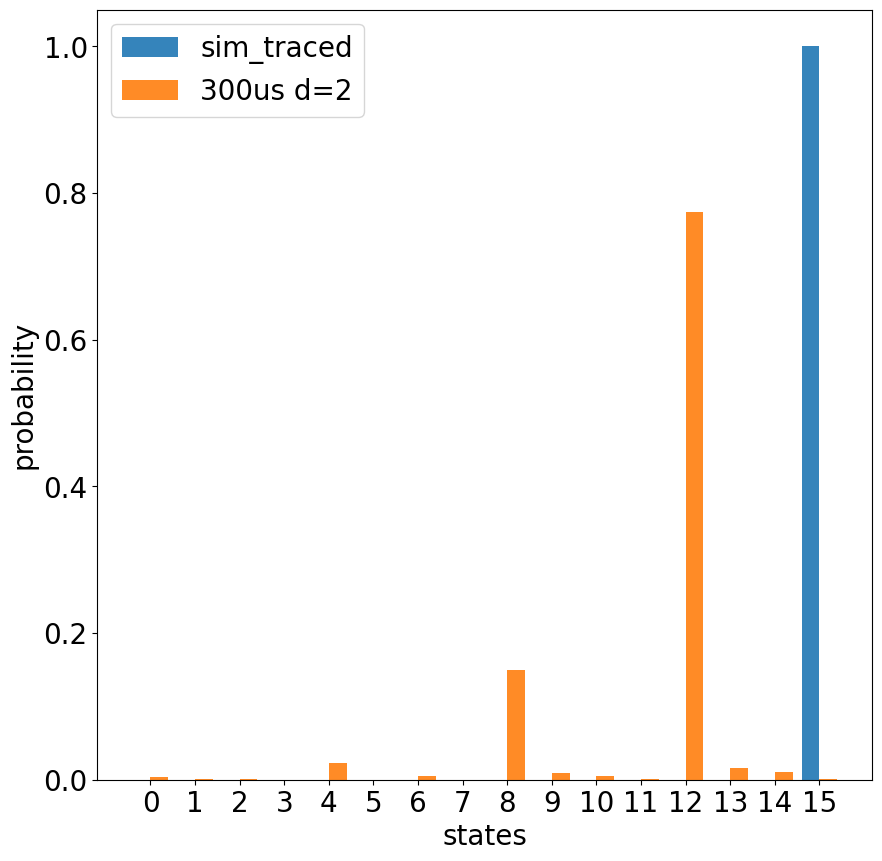

counts: [257, 22, 7, 1, 1596, 27, 25, 1, 2, 1, 2, 0, 36, 2, 21, 0]
counts_ibm_mapping_dic: {'0000': 257, '1000': 22, '0100': 7, '1100': 1, '0010': 1596, '1010': 27, '0110': 25, '1110': 1, '0001': 2, '1001': 1, '0101': 2, '1101': 0, '0011': 36, '1011': 2, '0111': 21, '1111': 0}


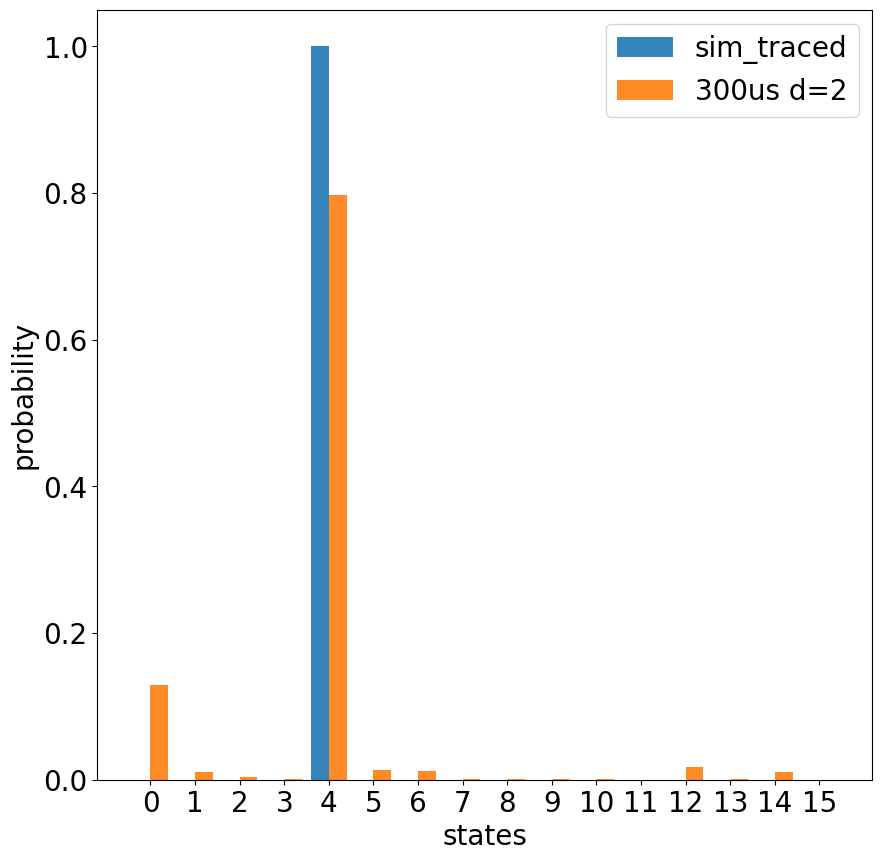

counts: [0, 6, 2, 7, 0, 25, 2, 128, 0, 2, 20, 127, 3, 58, 19, 1601]
counts_ibm_mapping_dic: {'0000': 0, '1000': 6, '0100': 2, '1100': 7, '0010': 0, '1010': 25, '0110': 2, '1110': 128, '0001': 0, '1001': 2, '0101': 20, '1101': 127, '0011': 3, '1011': 58, '0111': 19, '1111': 1601}


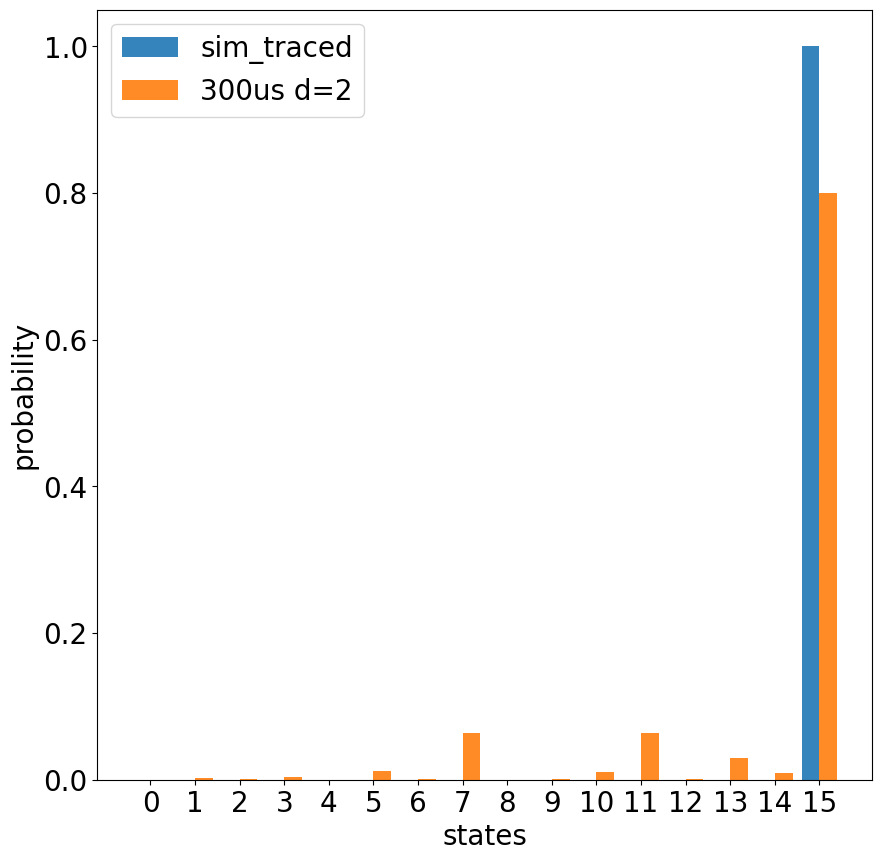

counts: [27, 1727, 1, 46, 14, 87, 1, 2, 1, 60, 0, 24, 1, 6, 1, 2]
counts_ibm_mapping_dic: {'0000': 27, '1000': 1727, '0100': 1, '1100': 46, '0010': 14, '1010': 87, '0110': 1, '1110': 2, '0001': 1, '1001': 60, '0101': 0, '1101': 24, '0011': 1, '1011': 6, '0111': 1, '1111': 2}


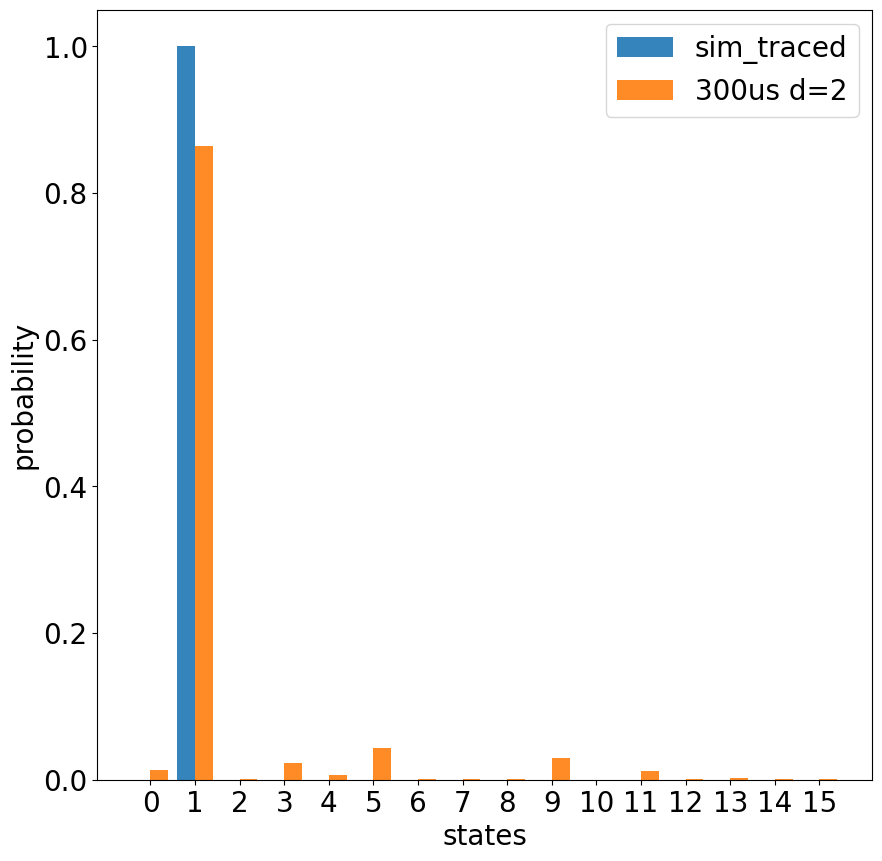

counts: [1, 26, 12, 187, 0, 5, 2, 60, 6, 23, 41, 1458, 0, 4, 17, 158]
counts_ibm_mapping_dic: {'0000': 1, '1000': 26, '0100': 12, '1100': 187, '0010': 0, '1010': 5, '0110': 2, '1110': 60, '0001': 6, '1001': 23, '0101': 41, '1101': 1458, '0011': 0, '1011': 4, '0111': 17, '1111': 158}


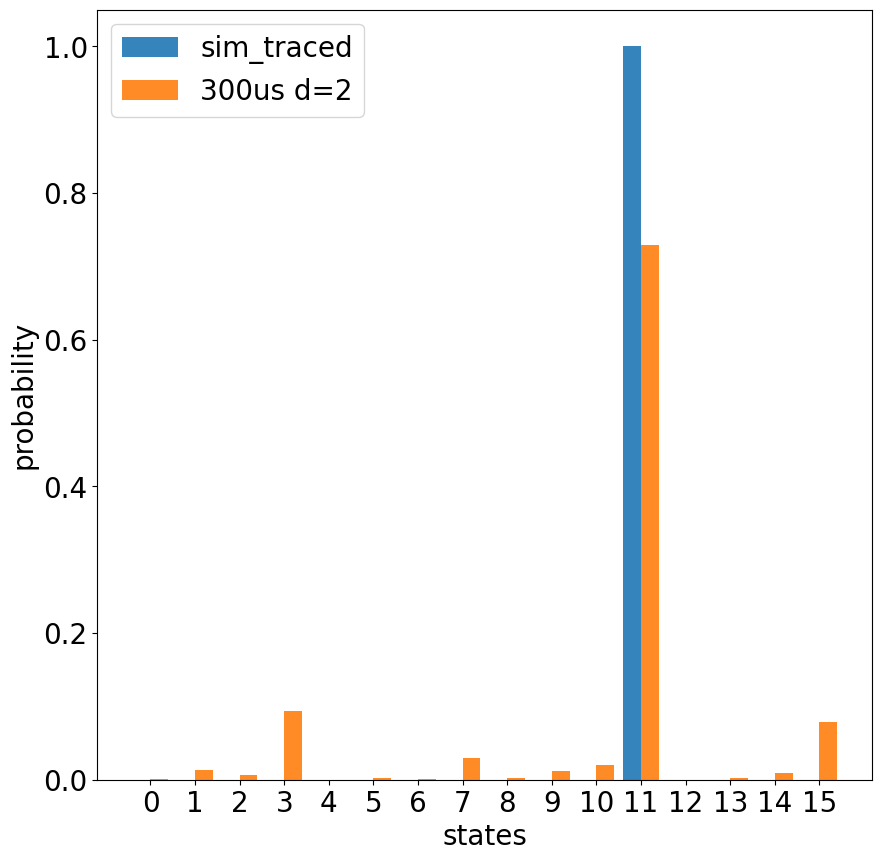

counts: [52, 0, 27, 0, 2, 1, 3, 0, 1711, 23, 26, 1, 124, 27, 3, 0]
counts_ibm_mapping_dic: {'0000': 52, '1000': 0, '0100': 27, '1100': 0, '0010': 2, '1010': 1, '0110': 3, '1110': 0, '0001': 1711, '1001': 23, '0101': 26, '1101': 1, '0011': 124, '1011': 27, '0111': 3, '1111': 0}


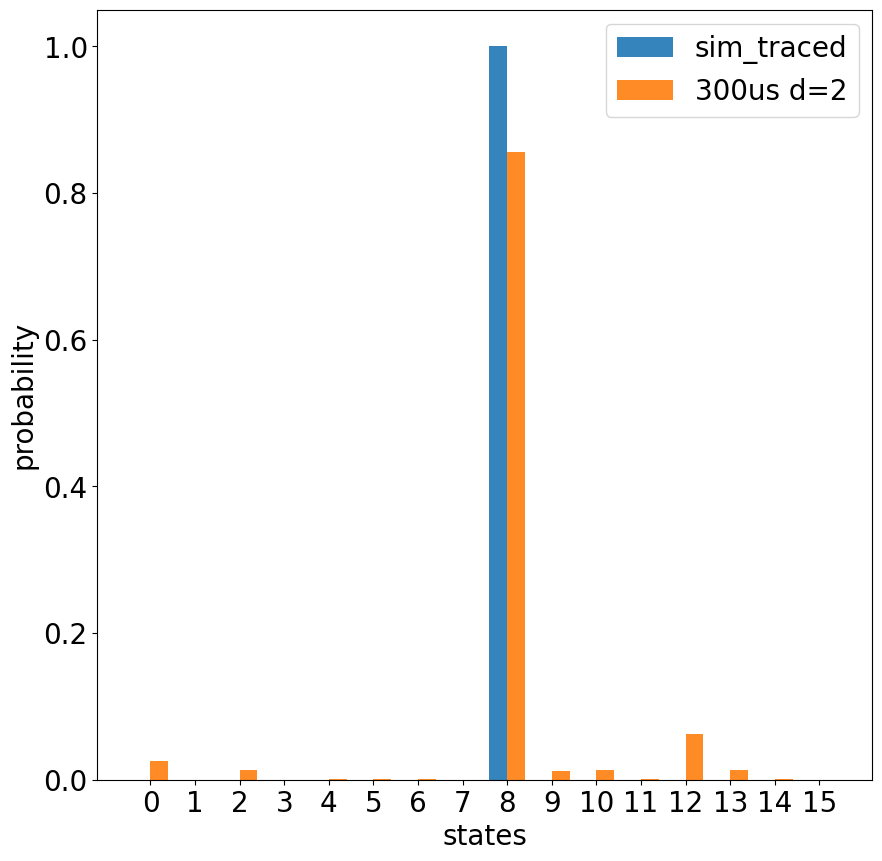

counts: [242, 26, 3, 1, 1488, 30, 27, 3, 50, 2, 5, 0, 110, 3, 10, 0]
counts_ibm_mapping_dic: {'0000': 242, '1000': 26, '0100': 3, '1100': 1, '0010': 1488, '1010': 30, '0110': 27, '1110': 3, '0001': 50, '1001': 2, '0101': 5, '1101': 0, '0011': 110, '1011': 3, '0111': 10, '1111': 0}


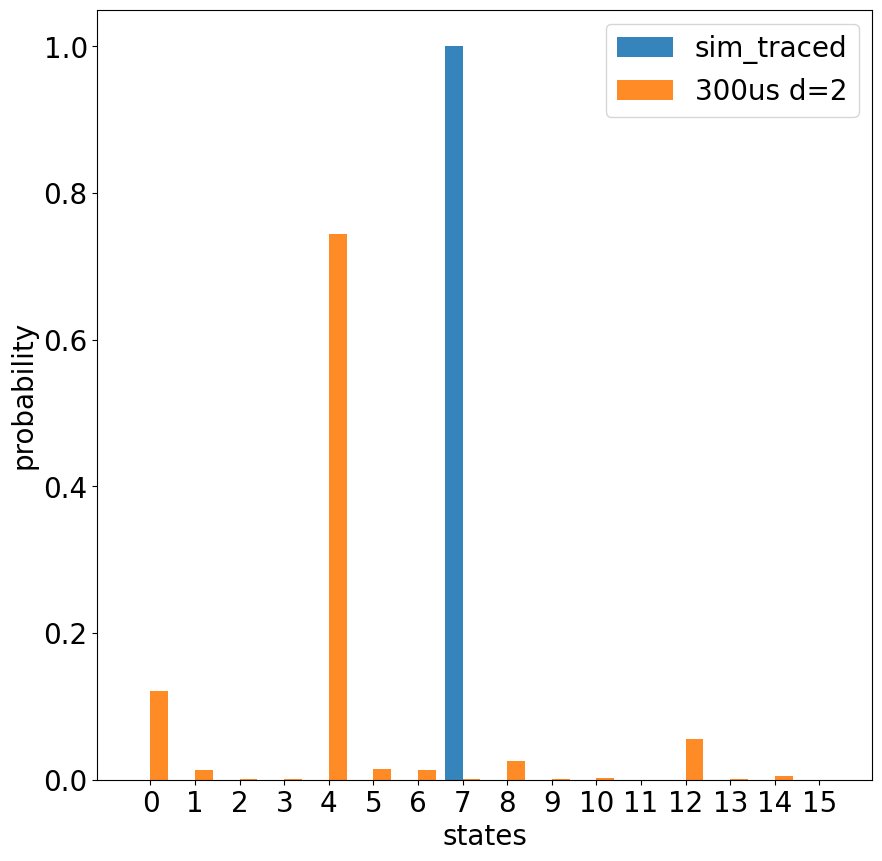

counts: [0, 3, 4, 18, 1, 30, 5, 127, 0, 6, 30, 128, 4, 63, 33, 1548]
counts_ibm_mapping_dic: {'0000': 0, '1000': 3, '0100': 4, '1100': 18, '0010': 1, '1010': 30, '0110': 5, '1110': 127, '0001': 0, '1001': 6, '0101': 30, '1101': 128, '0011': 4, '1011': 63, '0111': 33, '1111': 1548}


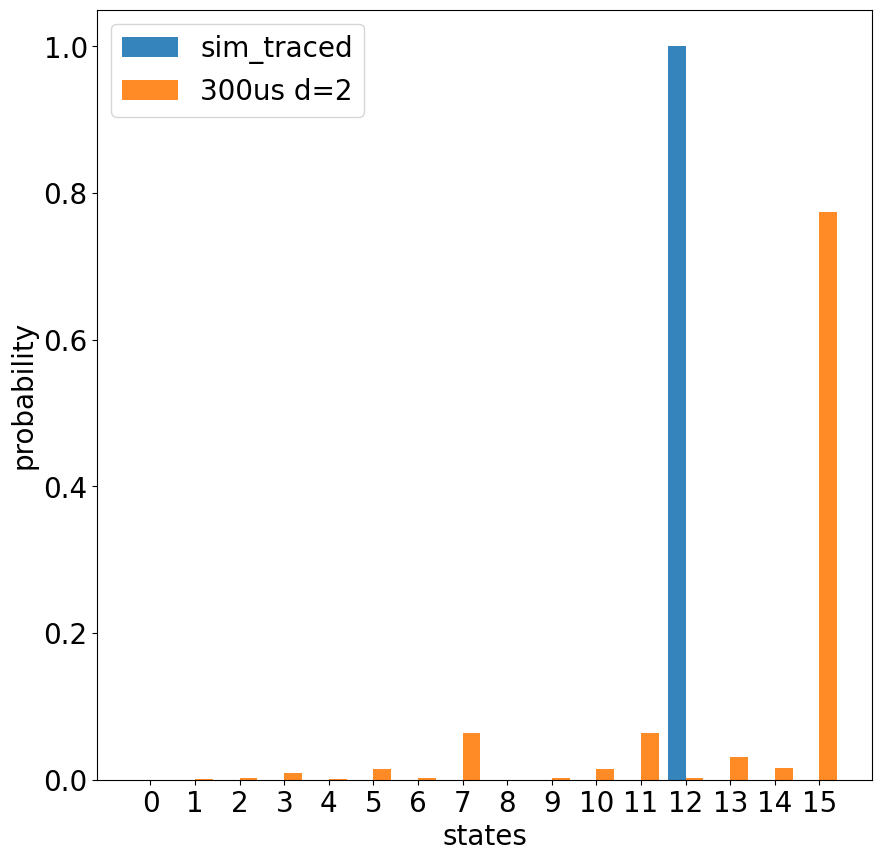

counts: [0, 33, 8, 119, 0, 3, 4, 12, 7, 50, 59, 1562, 2, 1, 28, 112]
counts_ibm_mapping_dic: {'0000': 0, '1000': 33, '0100': 8, '1100': 119, '0010': 0, '1010': 3, '0110': 4, '1110': 12, '0001': 7, '1001': 50, '0101': 59, '1101': 1562, '0011': 2, '1011': 1, '0111': 28, '1111': 112}


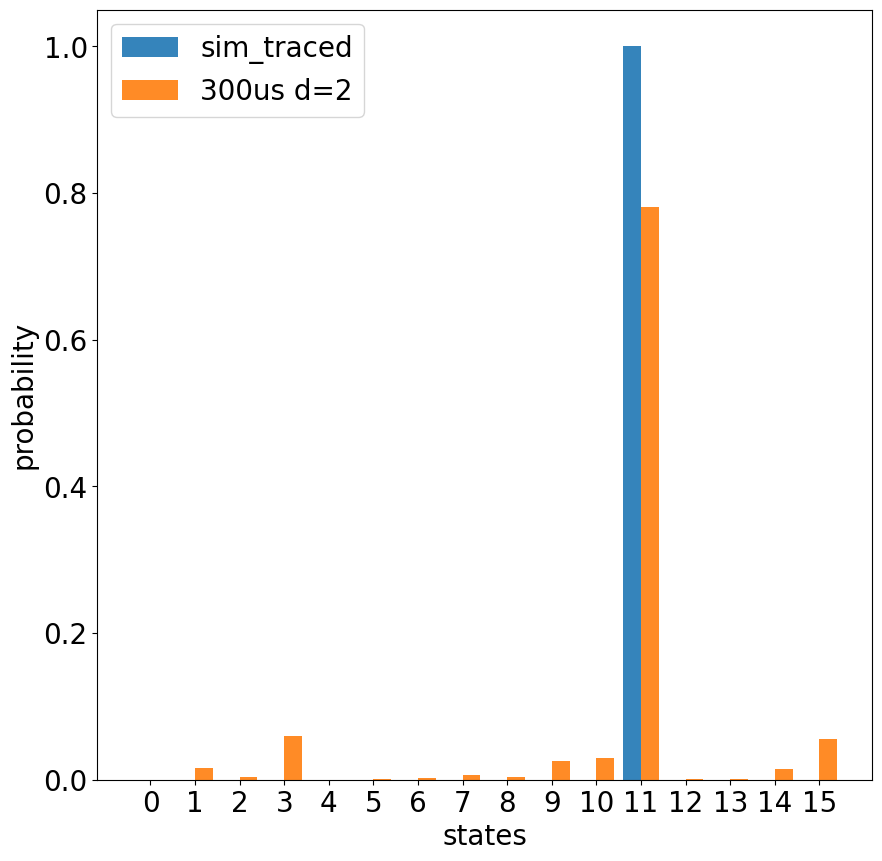

counts: [24, 61, 0, 2, 34, 1673, 1, 31, 2, 3, 0, 1, 4, 138, 1, 25]
counts_ibm_mapping_dic: {'0000': 24, '1000': 61, '0100': 0, '1100': 2, '0010': 34, '1010': 1673, '0110': 1, '1110': 31, '0001': 2, '1001': 3, '0101': 0, '1101': 1, '0011': 4, '1011': 138, '0111': 1, '1111': 25}


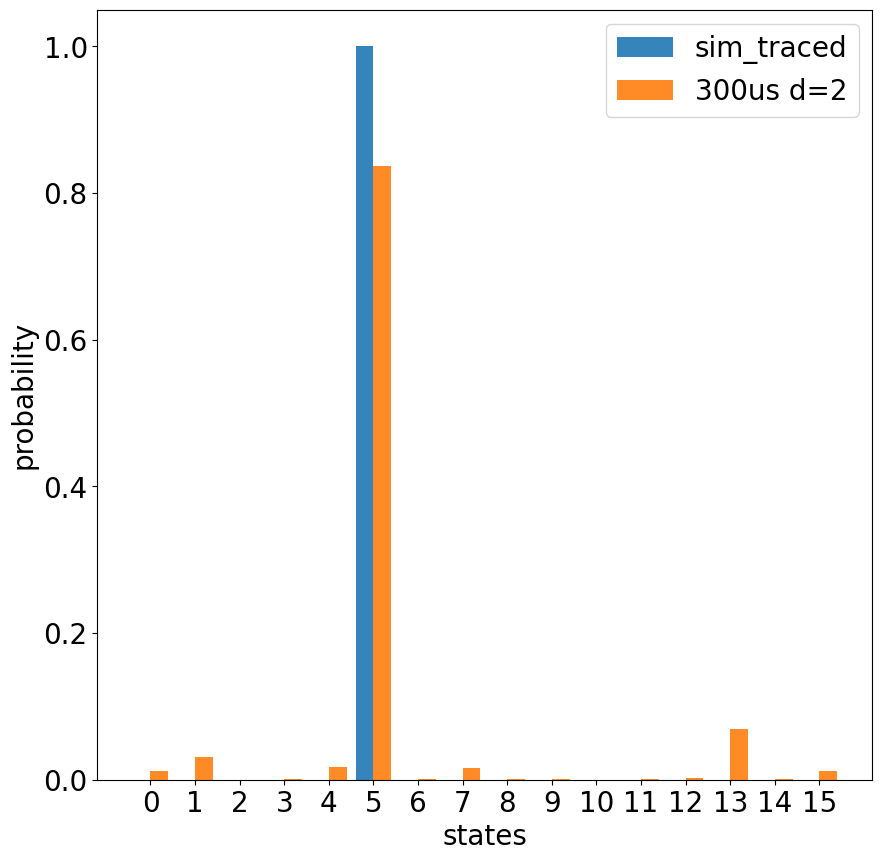

counts: [33, 8, 10, 5, 57, 3, 13, 1, 235, 29, 14, 2, 1532, 30, 27, 1]
counts_ibm_mapping_dic: {'0000': 33, '1000': 8, '0100': 10, '1100': 5, '0010': 57, '1010': 3, '0110': 13, '1110': 1, '0001': 235, '1001': 29, '0101': 14, '1101': 2, '0011': 1532, '1011': 30, '0111': 27, '1111': 1}


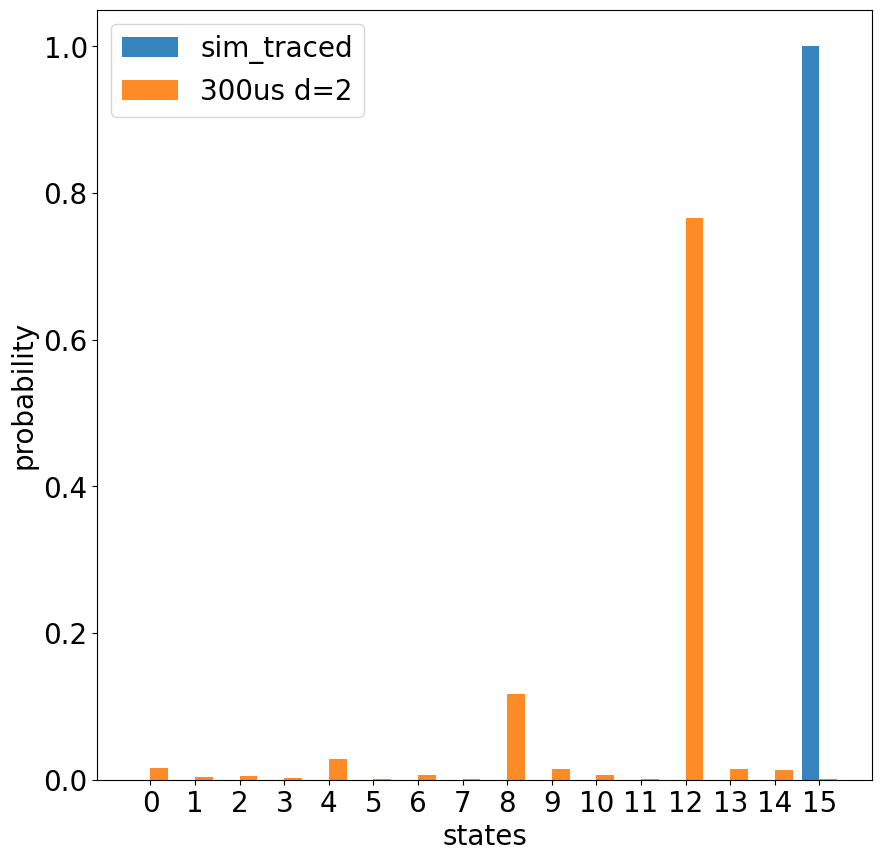

counts: [7, 29, 24, 1613, 0, 0, 24, 24, 3, 31, 6, 218, 1, 0, 2, 18]
counts_ibm_mapping_dic: {'0000': 7, '1000': 29, '0100': 24, '1100': 1613, '0010': 0, '1010': 0, '0110': 24, '1110': 24, '0001': 3, '1001': 31, '0101': 6, '1101': 218, '0011': 1, '1011': 0, '0111': 2, '1111': 18}


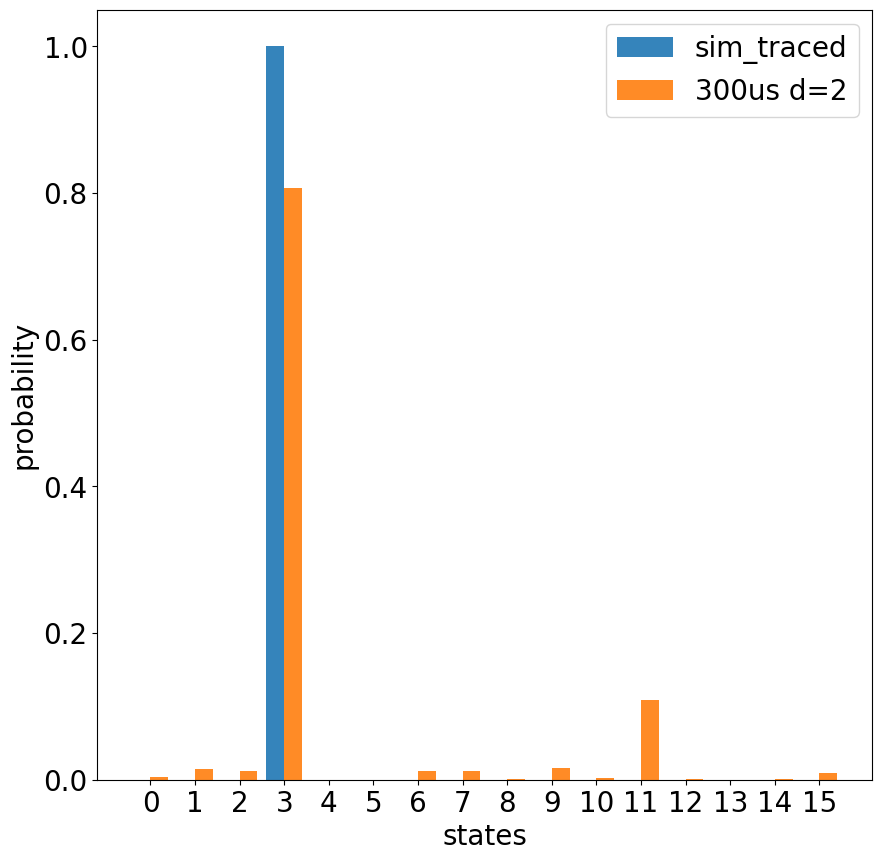

counts: [7, 2, 240, 27, 32, 4, 1489, 41, 4, 0, 15, 4, 32, 1, 99, 3]
counts_ibm_mapping_dic: {'0000': 7, '1000': 2, '0100': 240, '1100': 27, '0010': 32, '1010': 4, '0110': 1489, '1110': 41, '0001': 4, '1001': 0, '0101': 15, '1101': 4, '0011': 32, '1011': 1, '0111': 99, '1111': 3}


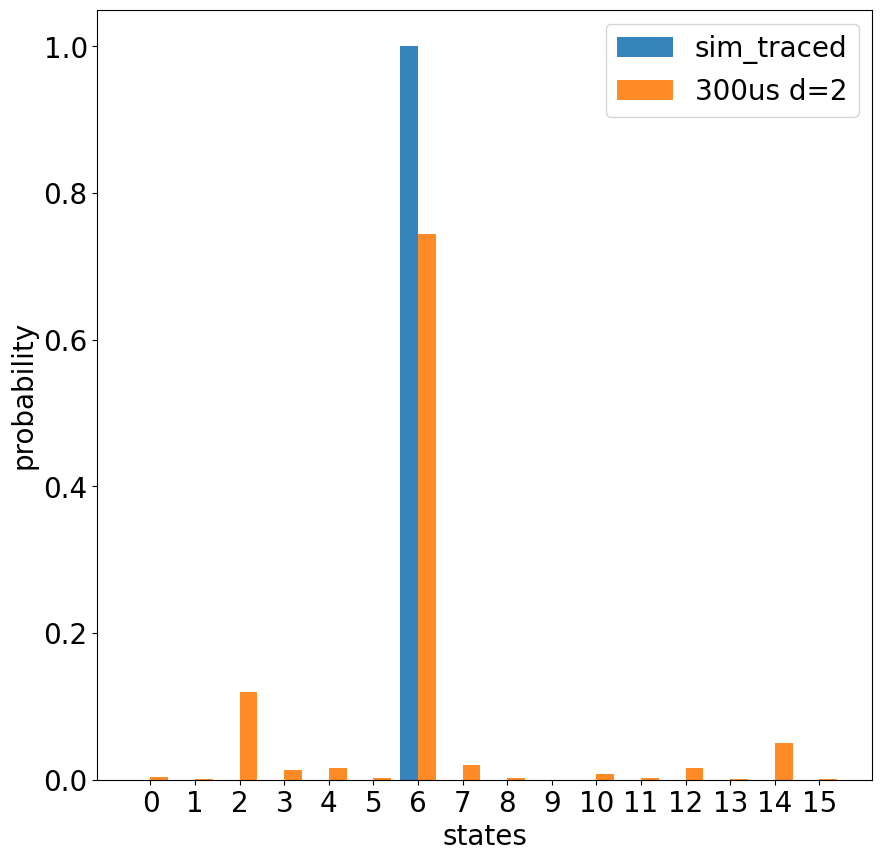

counts: [1533, 16, 14, 3, 286, 25, 5, 1, 69, 1, 16, 1, 18, 3, 9, 0]
counts_ibm_mapping_dic: {'0000': 1533, '1000': 16, '0100': 14, '1100': 3, '0010': 286, '1010': 25, '0110': 5, '1110': 1, '0001': 69, '1001': 1, '0101': 16, '1101': 1, '0011': 18, '1011': 3, '0111': 9, '1111': 0}


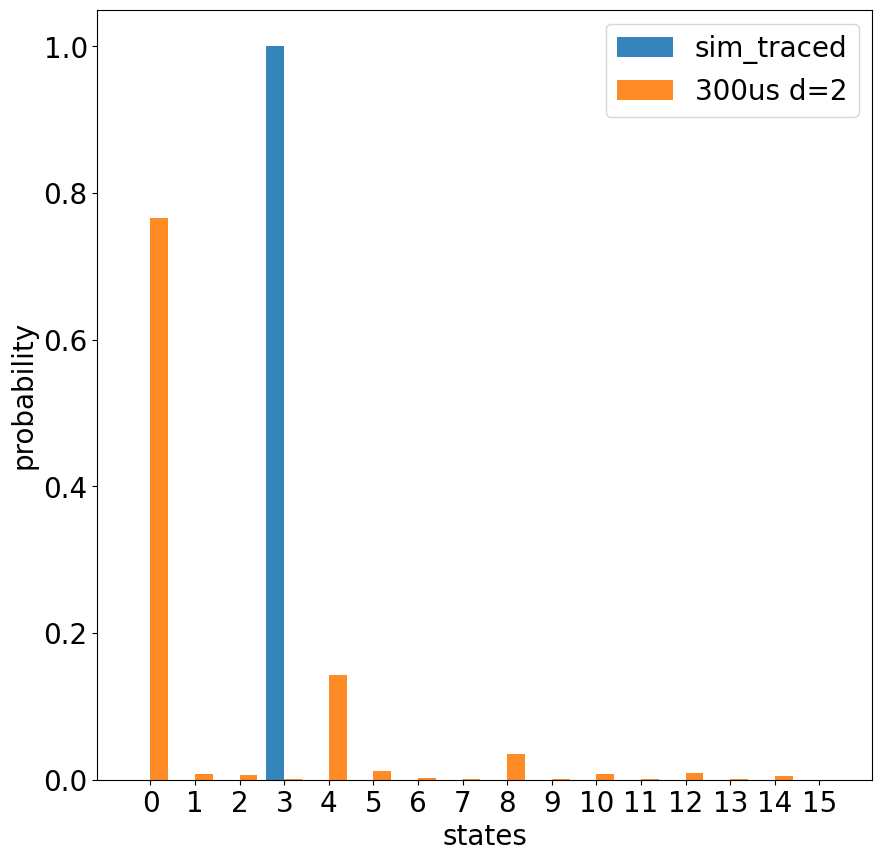

counts: [52, 3, 30, 1, 10, 3, 4, 0, 1684, 26, 19, 0, 135, 26, 5, 2]
counts_ibm_mapping_dic: {'0000': 52, '1000': 3, '0100': 30, '1100': 1, '0010': 10, '1010': 3, '0110': 4, '1110': 0, '0001': 1684, '1001': 26, '0101': 19, '1101': 0, '0011': 135, '1011': 26, '0111': 5, '1111': 2}


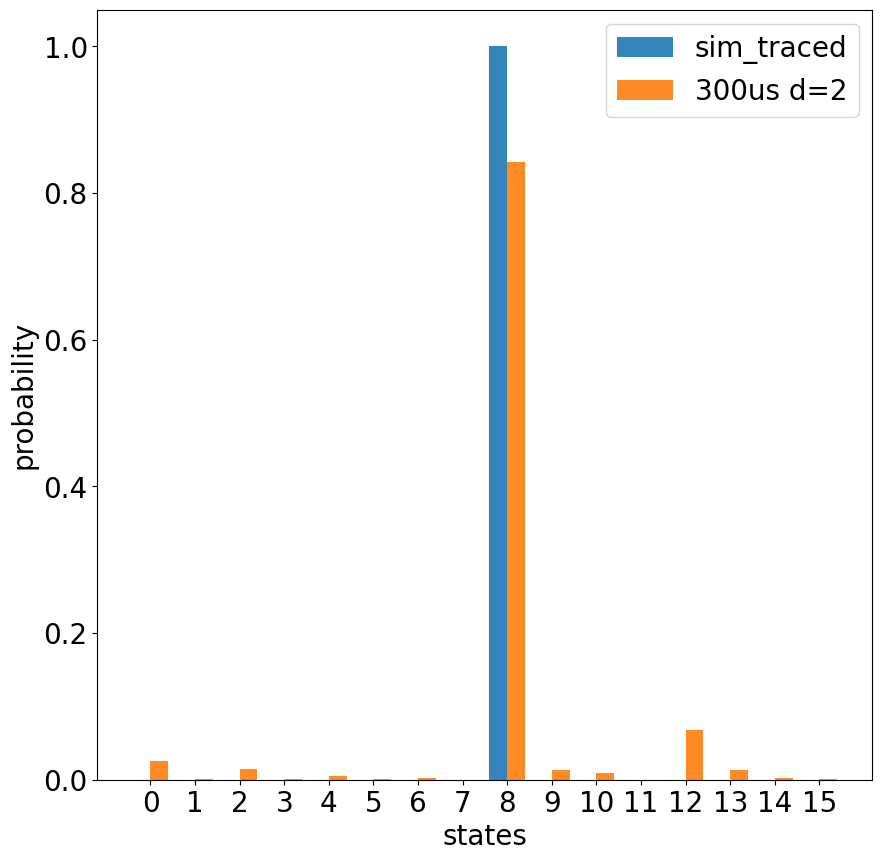

counts: [13, 0, 33, 4, 27, 0, 90, 1, 8, 0, 281, 28, 30, 1, 1445, 39]
counts_ibm_mapping_dic: {'0000': 13, '1000': 0, '0100': 33, '1100': 4, '0010': 27, '1010': 0, '0110': 90, '1110': 1, '0001': 8, '1001': 0, '0101': 281, '1101': 28, '0011': 30, '1011': 1, '0111': 1445, '1111': 39}


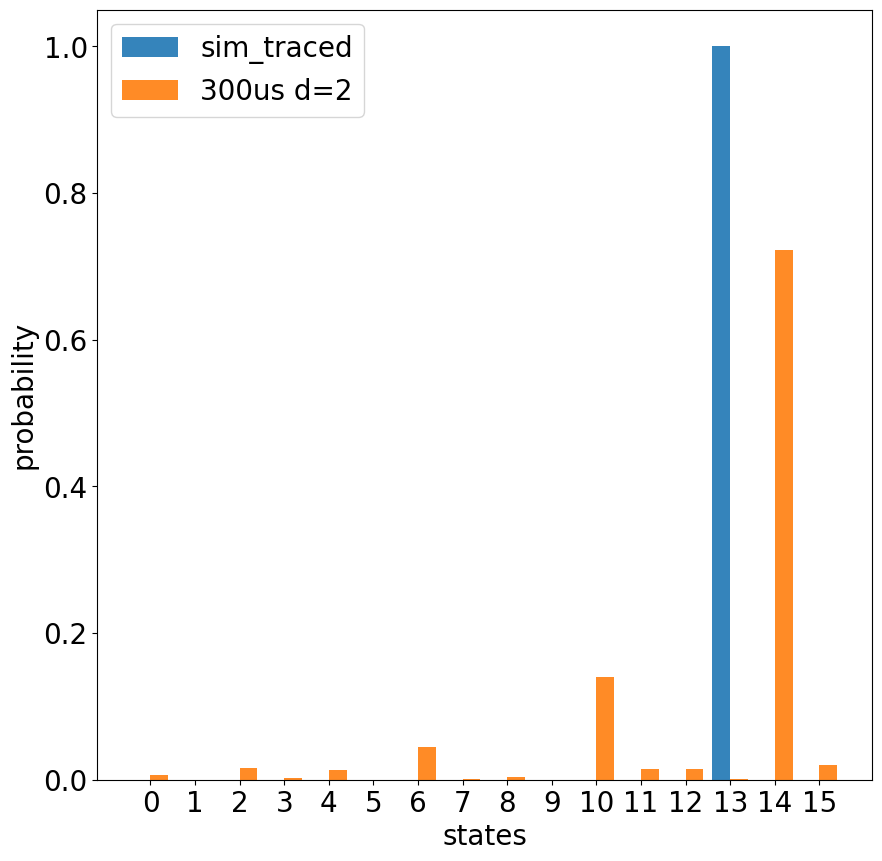

counts: [45, 1715, 2, 29, 20, 101, 0, 3, 1, 53, 0, 18, 1, 9, 2, 1]
counts_ibm_mapping_dic: {'0000': 45, '1000': 1715, '0100': 2, '1100': 29, '0010': 20, '1010': 101, '0110': 0, '1110': 3, '0001': 1, '1001': 53, '0101': 0, '1101': 18, '0011': 1, '1011': 9, '0111': 2, '1111': 1}


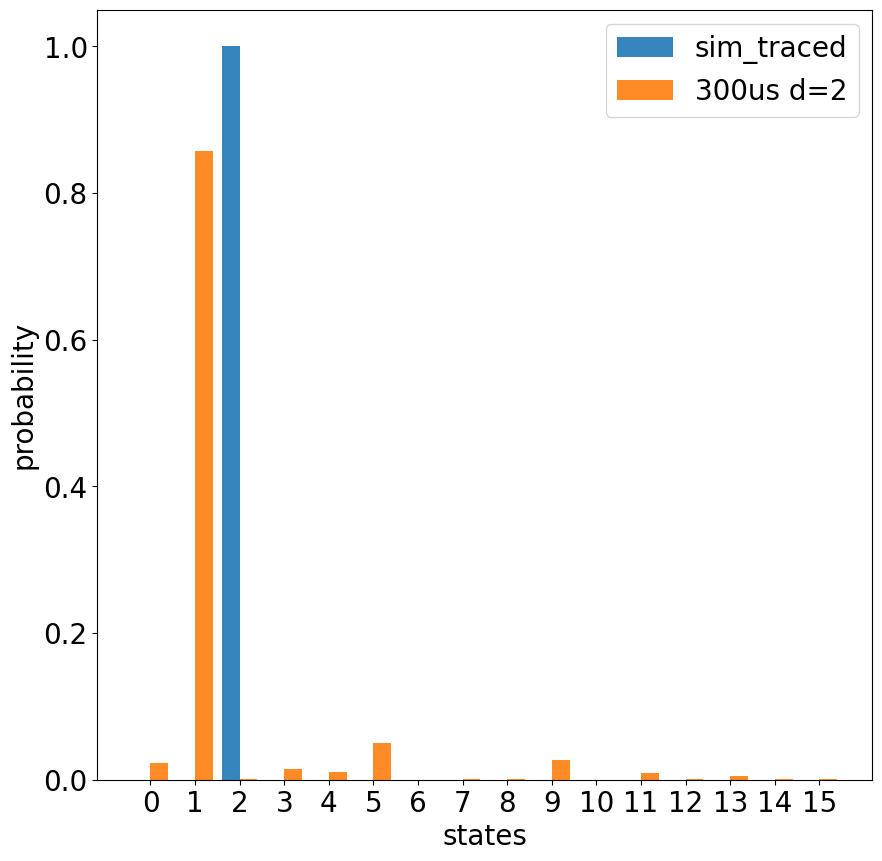

In [43]:
filenames_data=[]
counts_d2=[]
counts_d2_spam=[]
counts_d2_sim=[]
shots=2000
counts=[]
counts_spam=[]
counts_sim=[]

filenames_data=filenames_d2.copy()
print (filenames_data)
paf_data=paf_data_d2
circuit=c_d2
for i in range (len(filenames_data)):
#     print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    print ("counts:", counts)
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
    counts_d2.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     a_s=a
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d2_spam.append(counts_ibm_mapping_dic_spam)


    
    b_c.Interpret_GatesLab_Sequence(c_d2[i])
    # print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
    # counts_sim=[round(shots*x) for x in sim_traced.population]
    # counts_ibm_mapping_sim, counts_ibm_mapping_dic_sim=map_statepop_2_ibm_mapping(counts_sim,nqubit)
    # counts_d2_sim.append(counts_ibm_mapping_dic_sim)
    
    
#     Display_States_Population(states=[b,a,a_0703],label=["simulation","d=2 0711","0115 identity channel"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","300us d=2"])
# #       


In [44]:
# filenames_data=[]
# counts_d4=[]
# counts_d4_spam=[]
# counts=[]
# counts_spam=[]
# filenames_data=filenames_d4_0703.copy()
# print (filenames_data)
# paf_data=paf_data_d4_0703
# circuit=c_d4
# for i in range (len(filenames_data)):
# #     print (filenames_data[i])
#     a.Import(paf_data+filenames_data[i],keep_file=True)
#     data_traced=Trace_Out(a,[0,1,2,3])
#     counts=[round(shots*x) for x in  data_traced.population]
#     counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
#     counts_d4.append(counts_ibm_mapping_dic)
    
    
# #     a_s=spam1.Correct_SPAM(a)
# #     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
# #     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
# #     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
# #     counts_d4_spam.append(counts_ibm_mapping_dic_spam)
    
# #     a_0703.Import(paf_data_d4_0703+filenames_d4_0703[i],keep_file=True)
# #     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])

#     b_c.Interpret_GatesLab_Sequence(circuit[i])
#     print (circuit[i])
#     b=b_c.Simulate()
#     sim_traced=Trace_Out(b,[0,1,2,3])
# #     Display_States_Population(states=[b,a,a_s],label=["simulation","d=4","spam"])
#     Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])
# # #         

['2024-02-06-190742_Line_001.txt', '2024-02-06-190818_Line_002.txt', '2024-02-06-190855_Line_003.txt', '2024-02-06-190931_Line_004.txt', '2024-02-06-191009_Line_005.txt', '2024-02-06-191125_Line_006.txt', '2024-02-06-191201_Line_007.txt', '2024-02-06-191239_Line_008.txt', '2024-02-06-191316_Line_009.txt', '2024-02-06-191352_Line_010.txt', '2024-02-06-205132_Line_011.txt', '2024-02-06-205208_Line_012.txt', '2024-02-06-205245_Line_013.txt', '2024-02-06-205321_Line_014.txt', '2024-02-06-205359_Line_015.txt', '2024-02-06-205516_Line_016.txt', '2024-02-06-205552_Line_017.txt', '2024-02-06-205629_Line_018.txt', '2024-02-06-205705_Line_019.txt', '2024-02-06-205742_Line_020.txt']
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:FTXA230.2500+:AZ

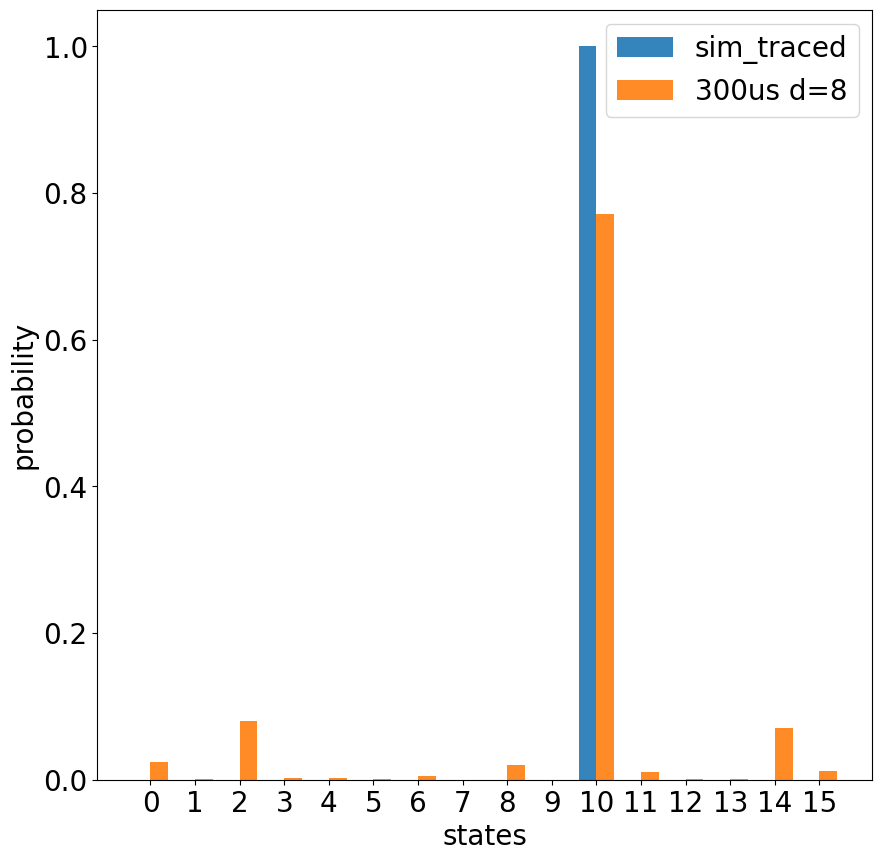

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



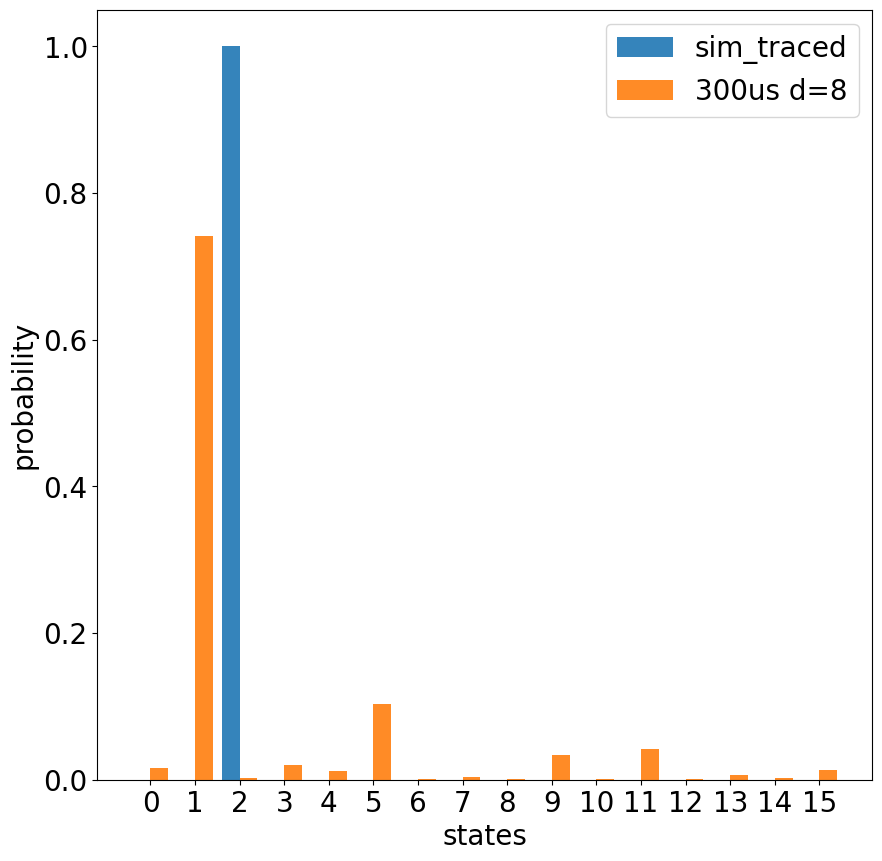

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



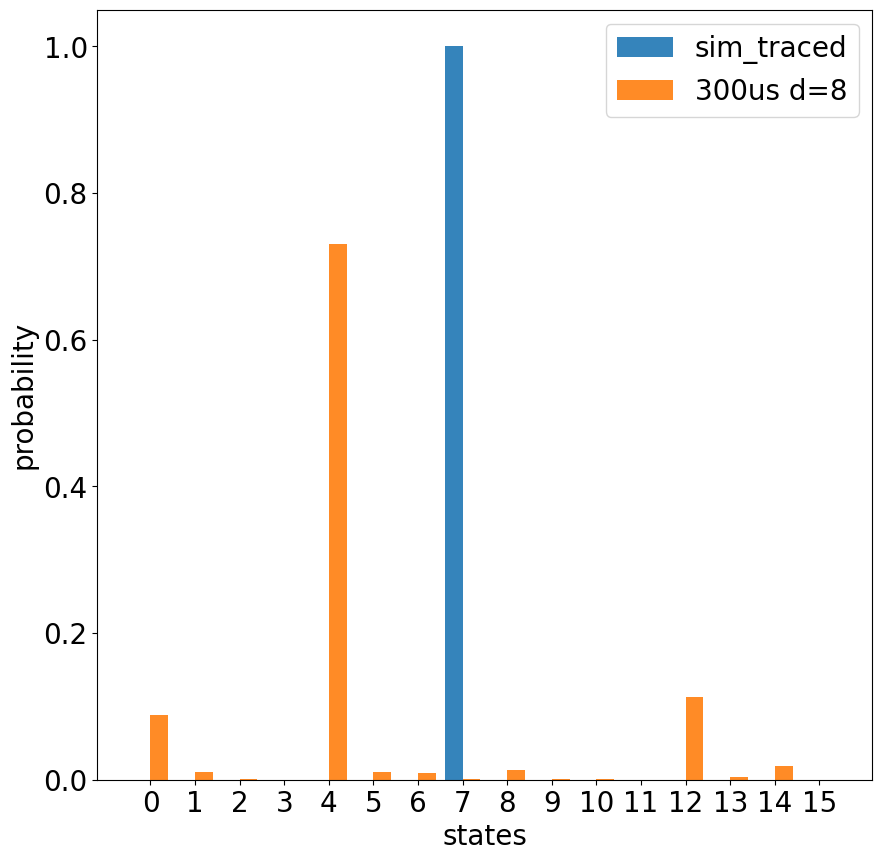

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



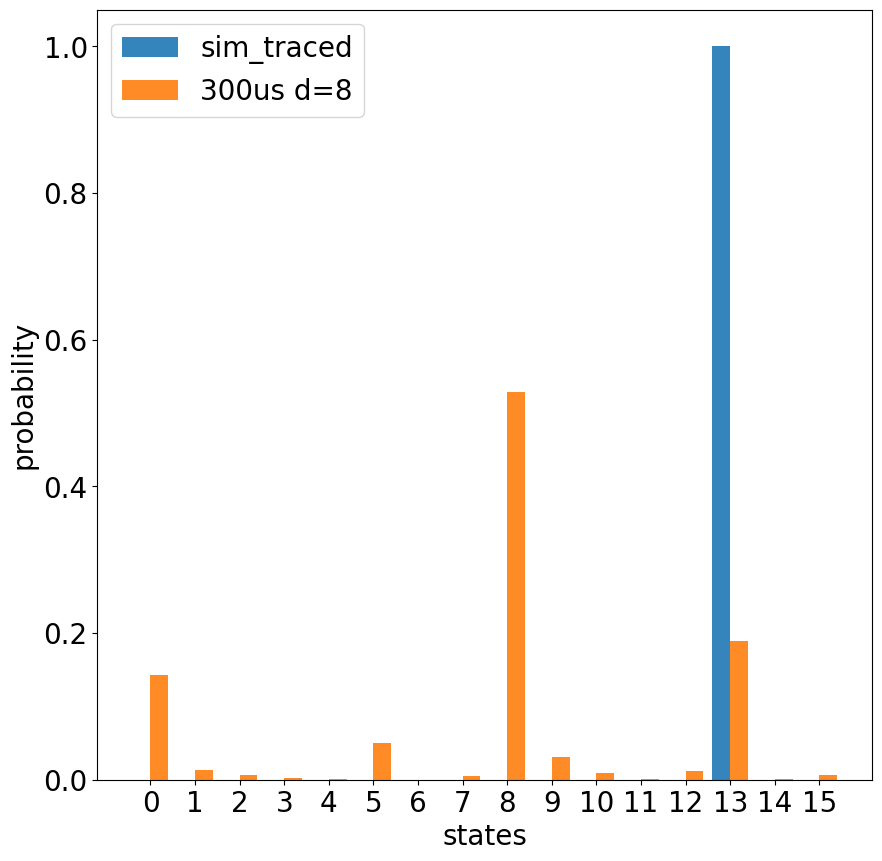

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



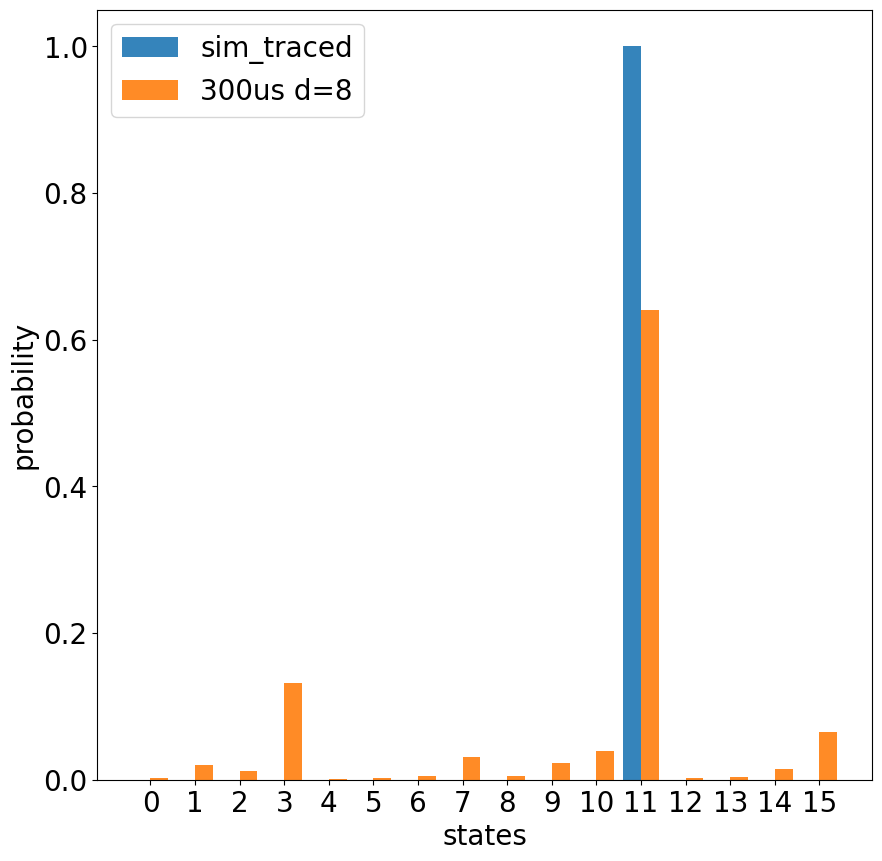

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:FTXA230.2500+:RY+31:FTXA230.2500+:FTXA230.2500+:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



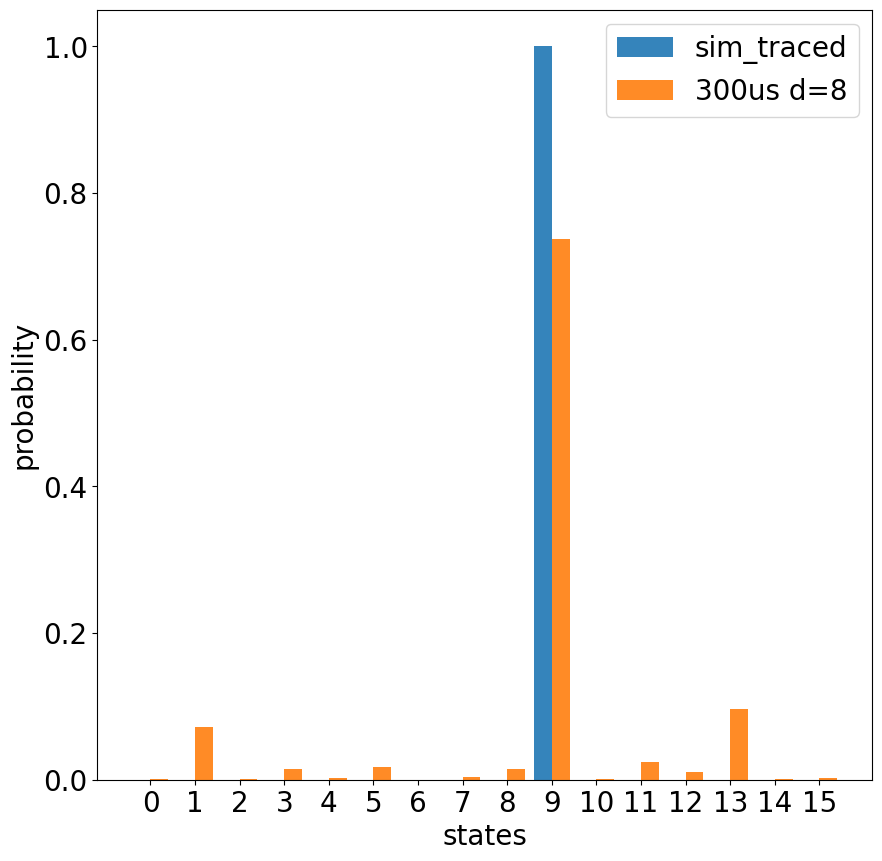

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



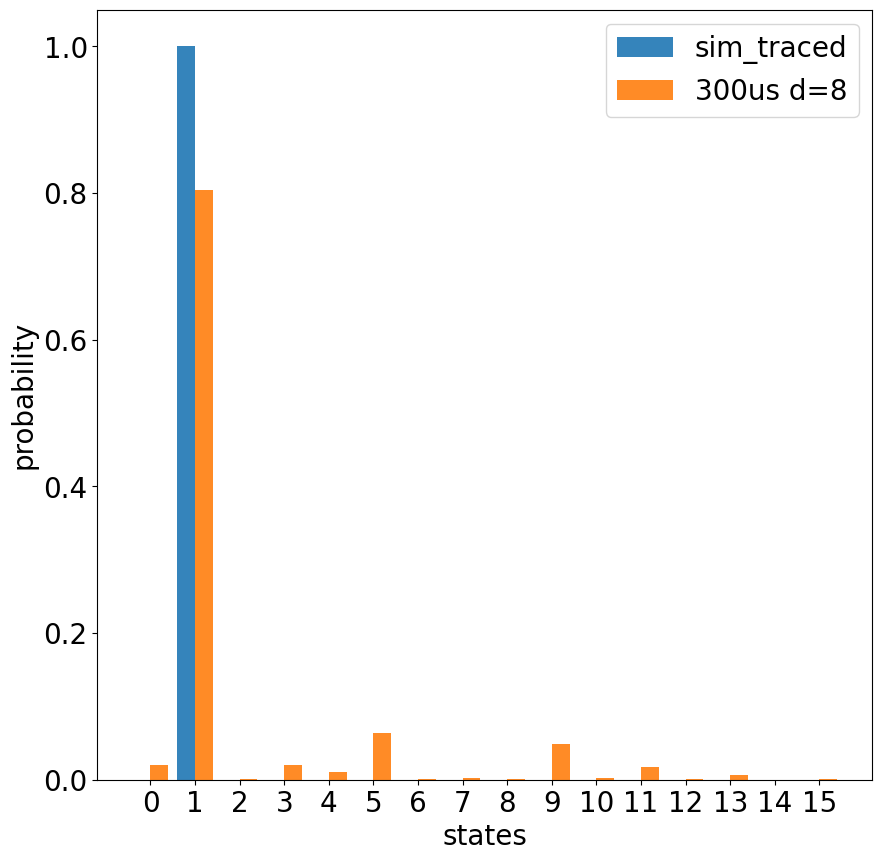

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



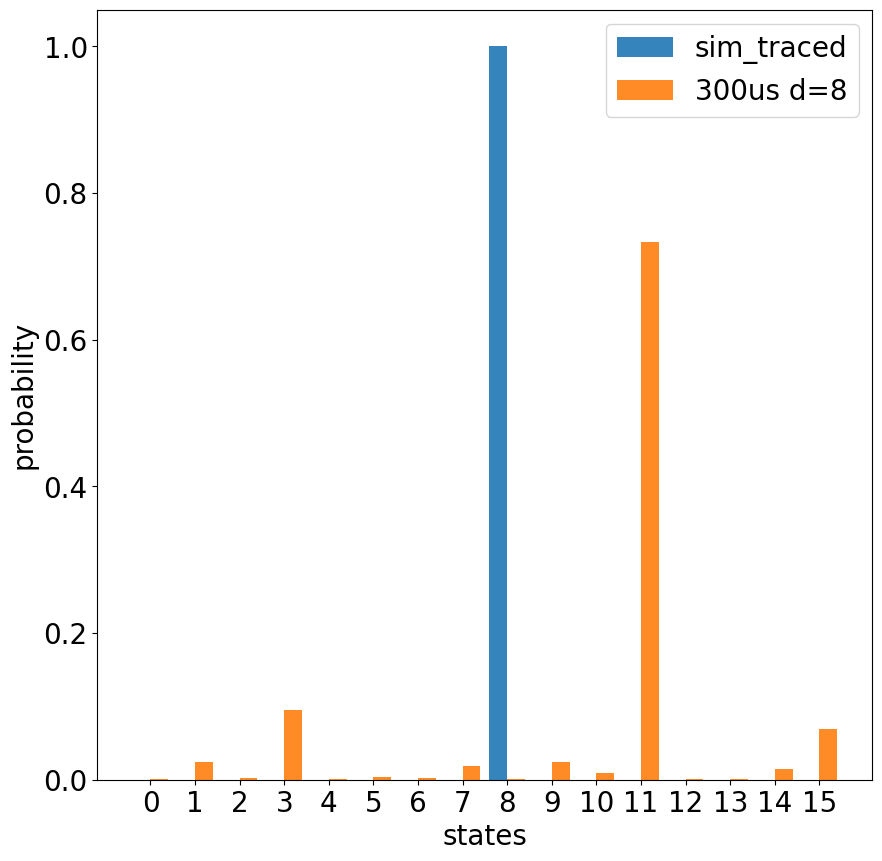

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



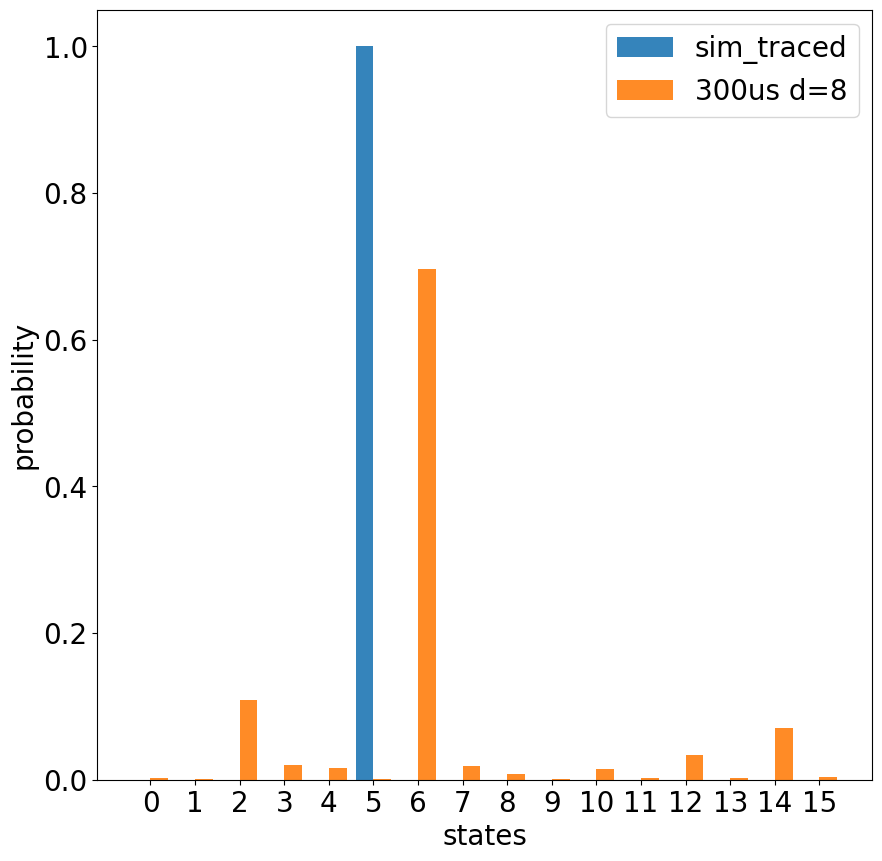

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:FTXA230.2500+:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



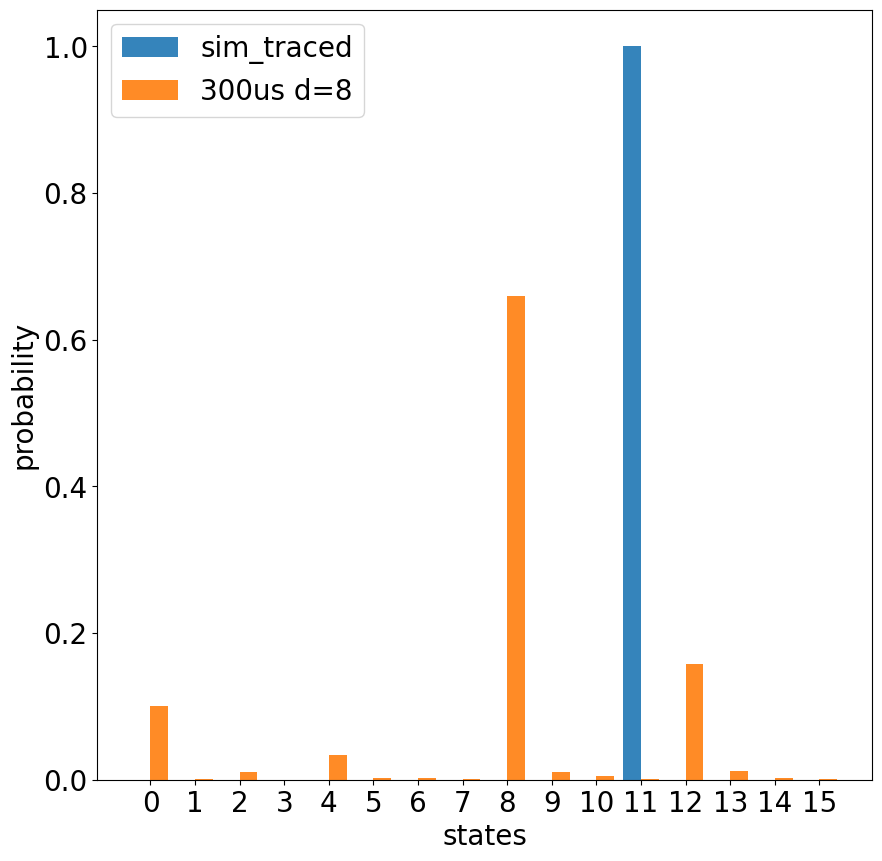

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



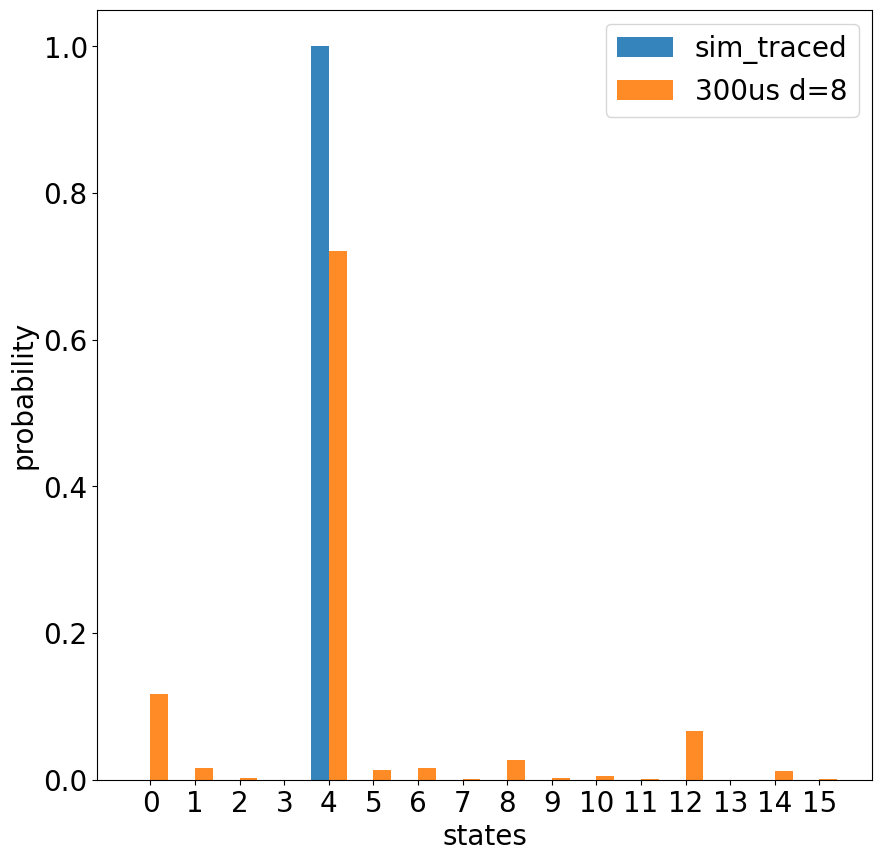

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



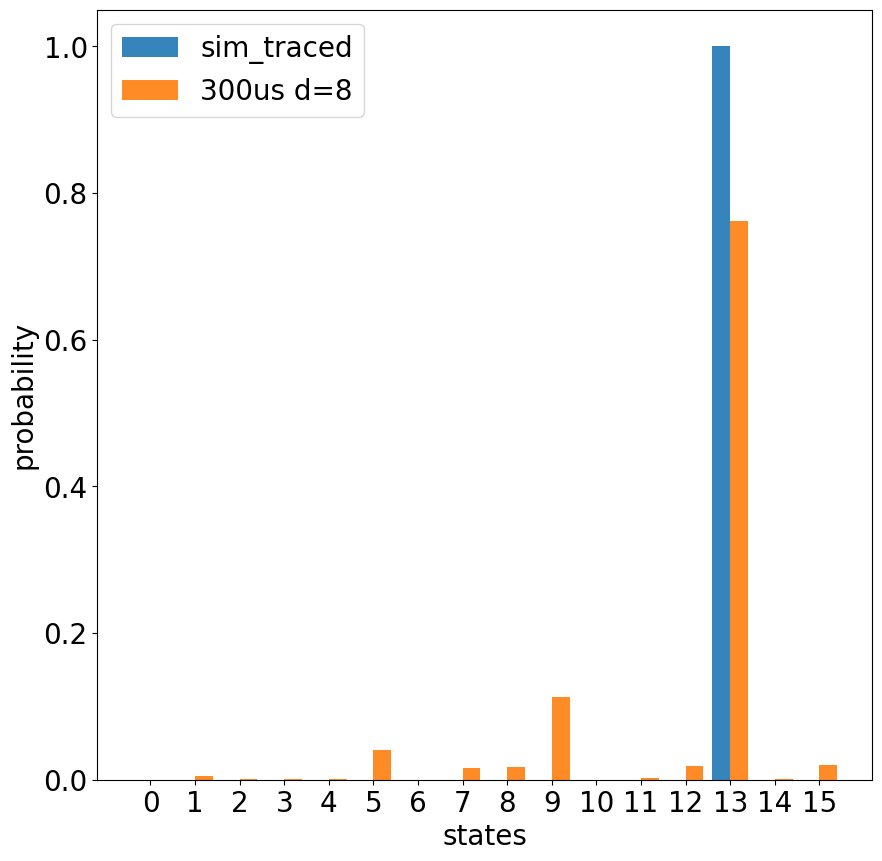

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



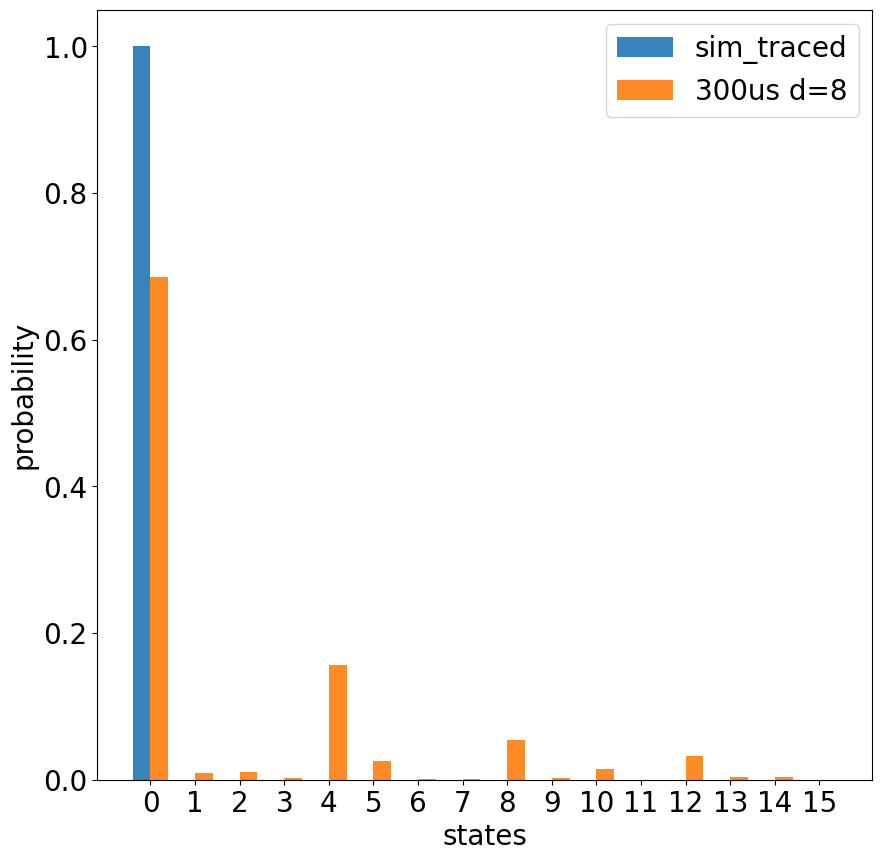

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



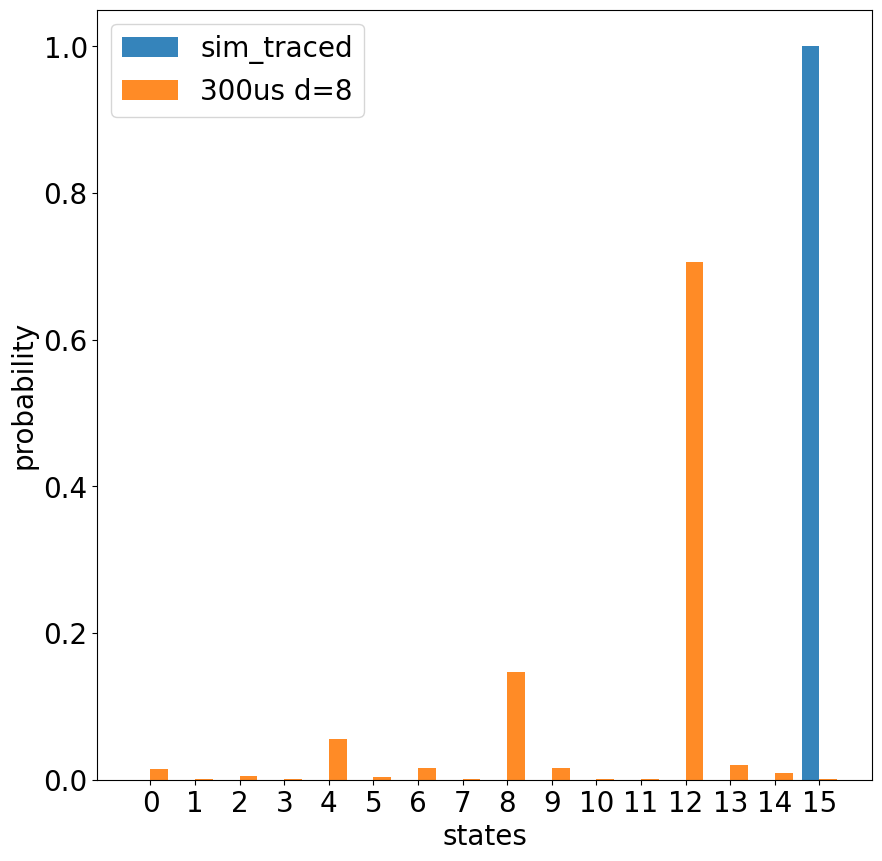

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



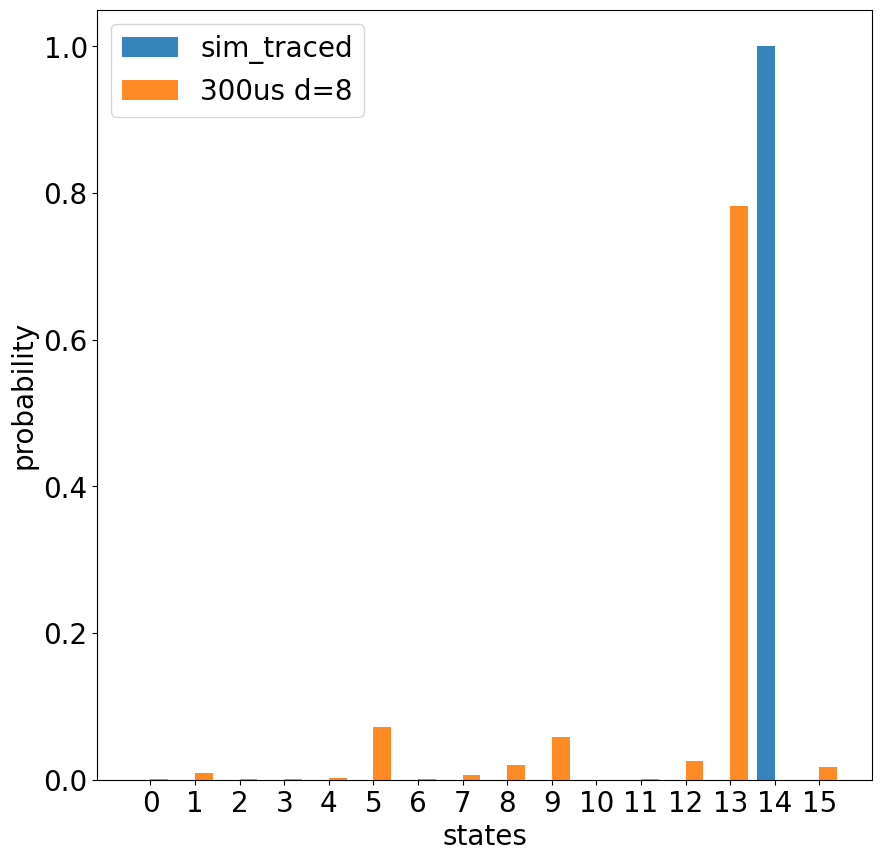

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



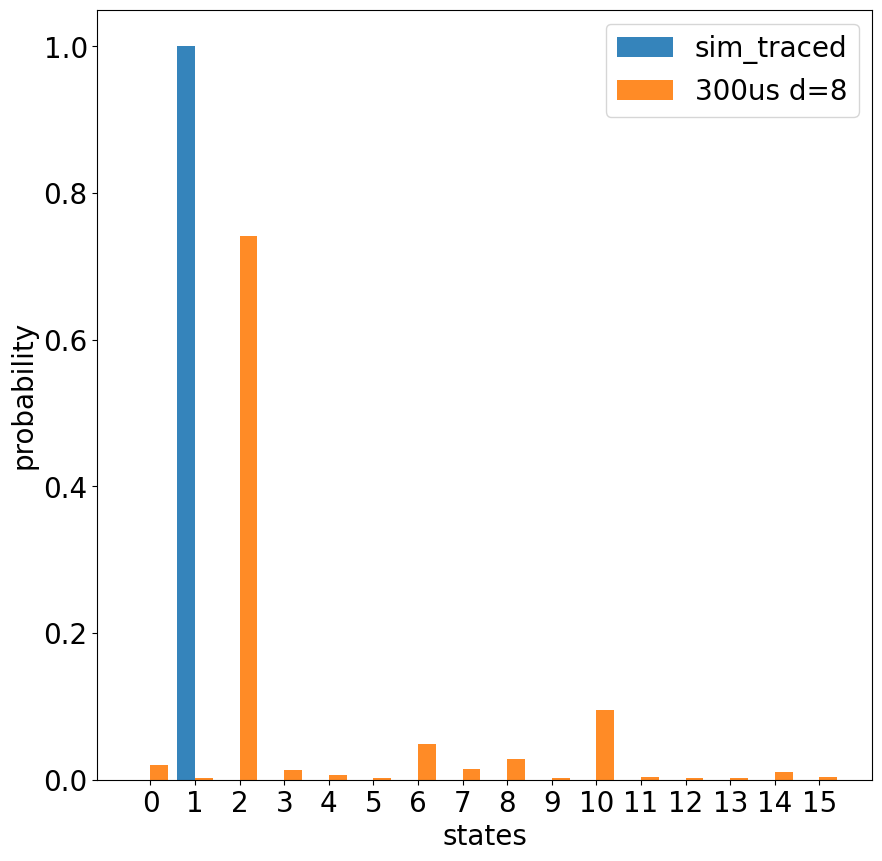

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



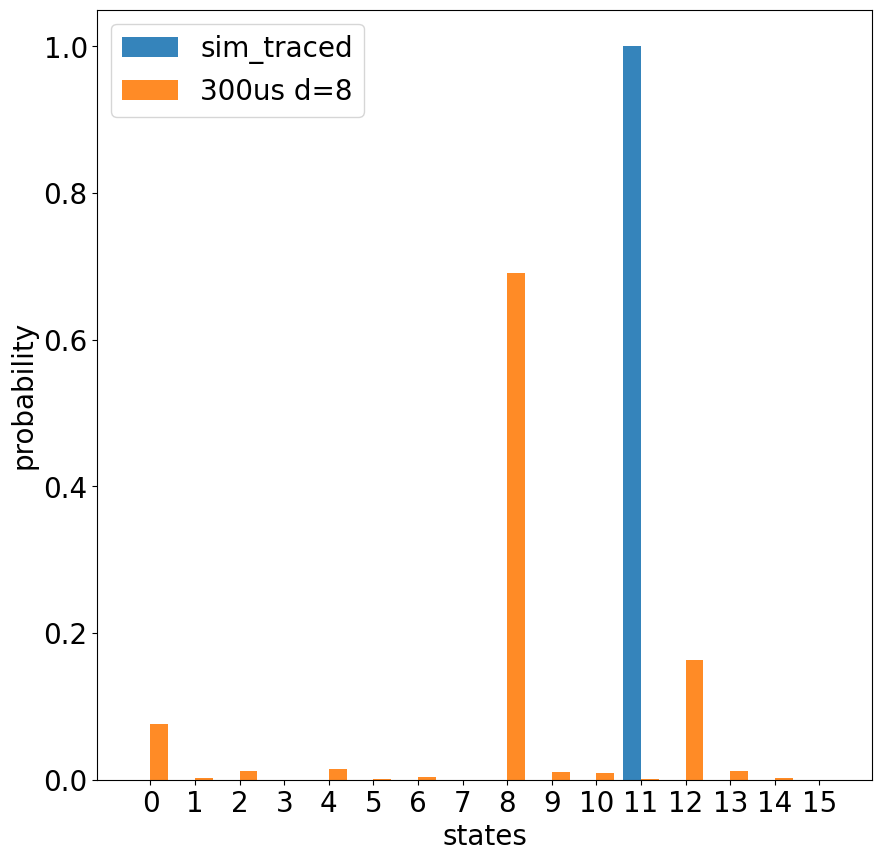

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



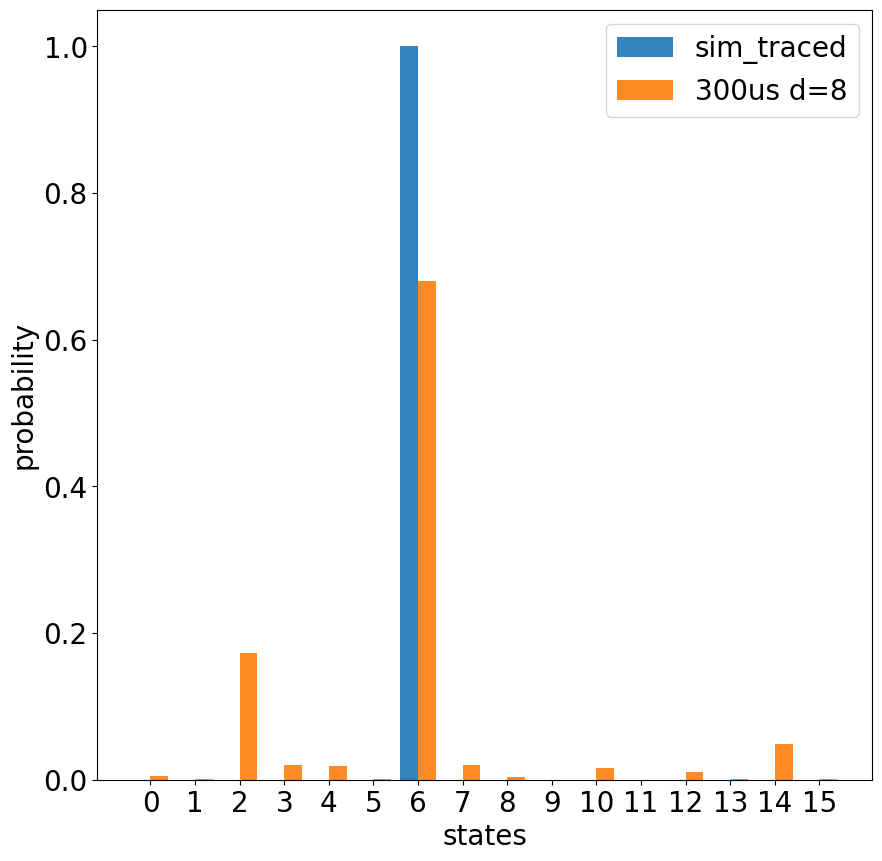

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



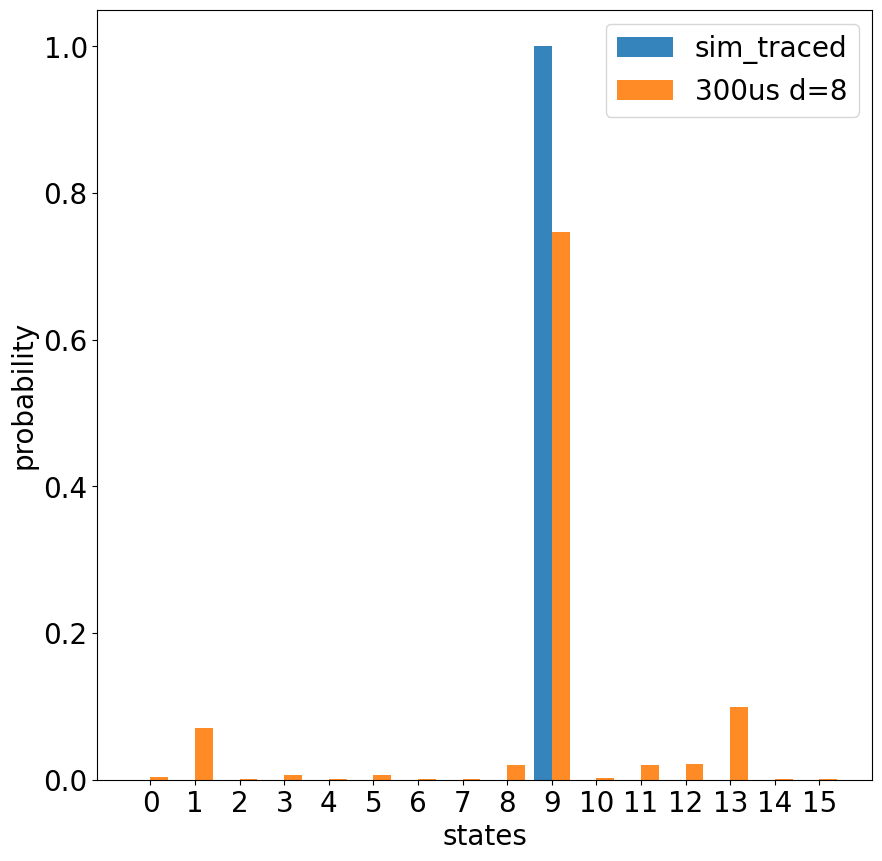

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



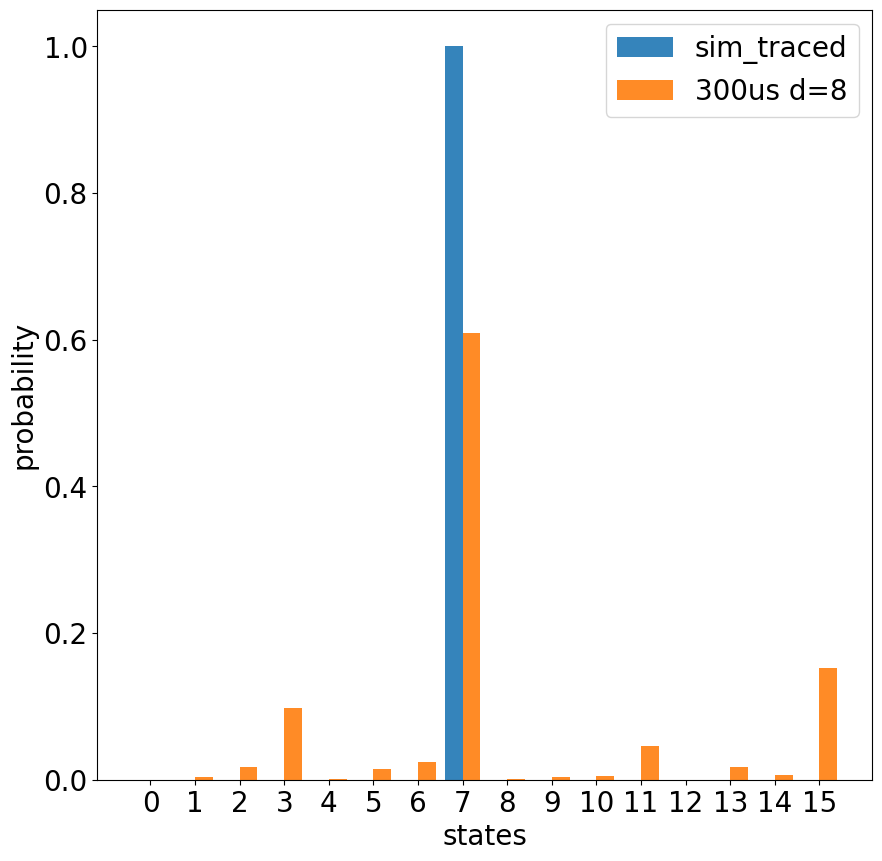

In [45]:
filenames_data=[]
counts_d8=[]
counts_d8_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d8.copy()
print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d8
circuit=c_d8
for i in range (len(filenames_data)):
#     print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d8.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d8_0703+filenames_d8_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","300us d=8"])

In [46]:
# filenames_data=[]
# counts_d16=[]
# counts_d16_spam=[]
# counts=[]
# counts_spam=[]
# filenames_data=filenames_d16_0115.copy()
# print (filenames_data)
# # # print (len(filenames_data))
# paf_data=paf_data_d16_0115
# circuit=c_d16
# for i in range (len(filenames_data)):
#     print (filenames_data[i])
#     a.Import(paf_data+filenames_data[i],keep_file=True)
#     data_traced=Trace_Out(a,[0,1,2,3])
#     counts=[round(shots*x) for x in  data_traced.population]
#     counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
#     counts_d16.append(counts_ibm_mapping_dic)
    
# #     a_s=spam1.Correct_SPAM(a)
# #     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
# #     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
# #     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
# #     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
# #     a_0703.Import(paf_data_d16_0115+filenames_d16_0115[i],keep_file=True)
# #     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
#     b_c.Interpret_GatesLab_Sequence(circuit[i])
#     print (circuit[i])
#     b=b_c.Simulate()
#     sim_traced=Trace_Out(b,[0,1,2,3])
# #     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
#     Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","0115"])

['2024-02-06-191807_Line_001.txt', '2024-02-06-191945_Line_002.txt', '2024-02-06-192128_Line_003.txt', '2024-02-06-192307_Line_004.txt', '2024-02-06-192524_Line_005.txt', '2024-02-06-192704_Line_006.txt', '2024-02-06-194004_Line_007.txt', '2024-02-06-194145_Line_008.txt', '2024-02-06-194323_Line_009.txt', '2024-02-06-194503_Line_010.txt', '2024-02-06-194723_Line_011.txt', '2024-02-06-194900_Line_012.txt', '2024-02-06-195040_Line_013.txt', '2024-02-06-195219_Line_014.txt', '2024-02-06-195438_Line_015.txt', '2024-02-06-195619_Line_016.txt', '2024-02-06-195802_Line_017.txt', '2024-02-06-195941_Line_018.txt', '2024-02-06-200203_Line_019.txt', '2024-02-06-201533_Line_020.txt']
2024-02-06-191807_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA2

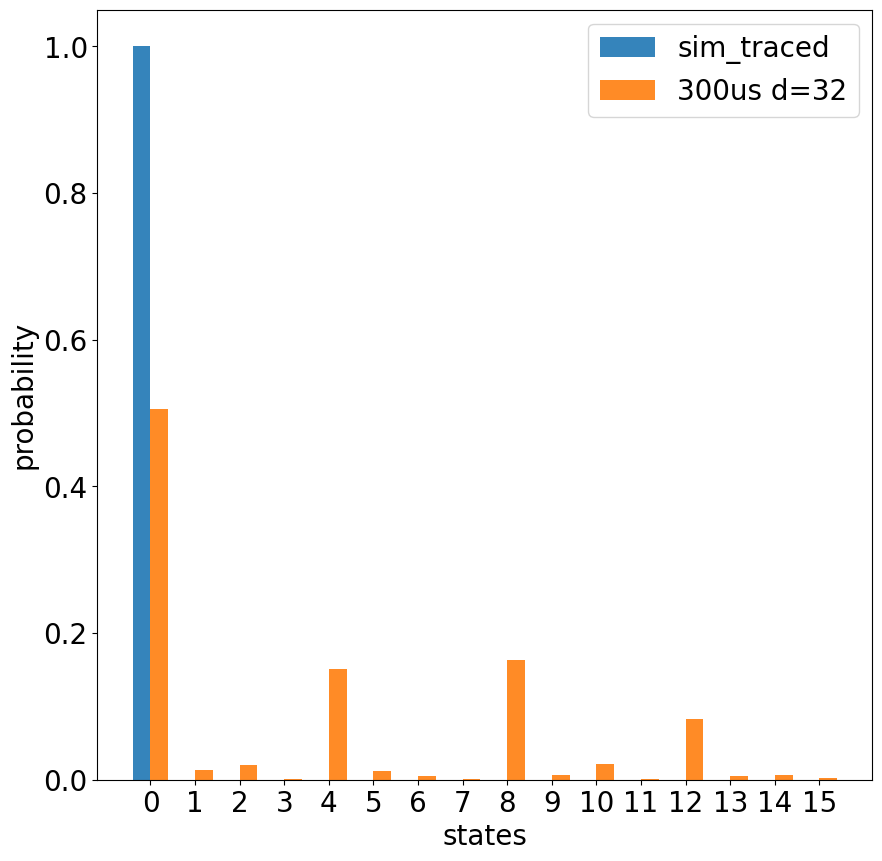

2024-02-06-191945_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:FTXA230.2500+:RX+21:FTXA230.2500+:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-

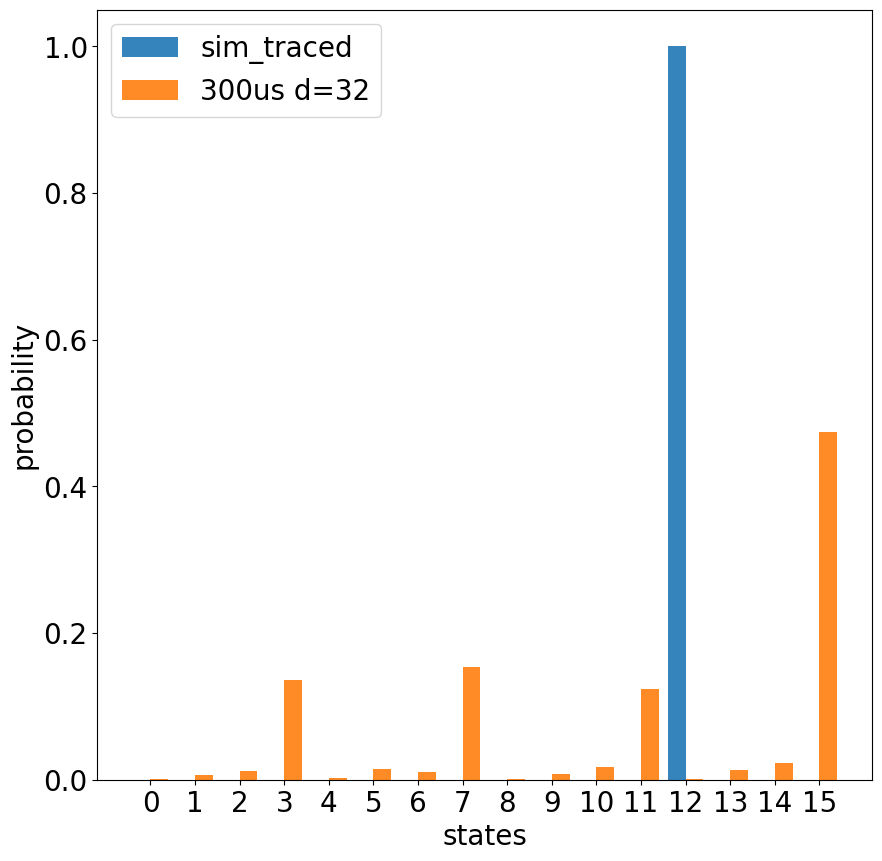

2024-02-06-192128_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:

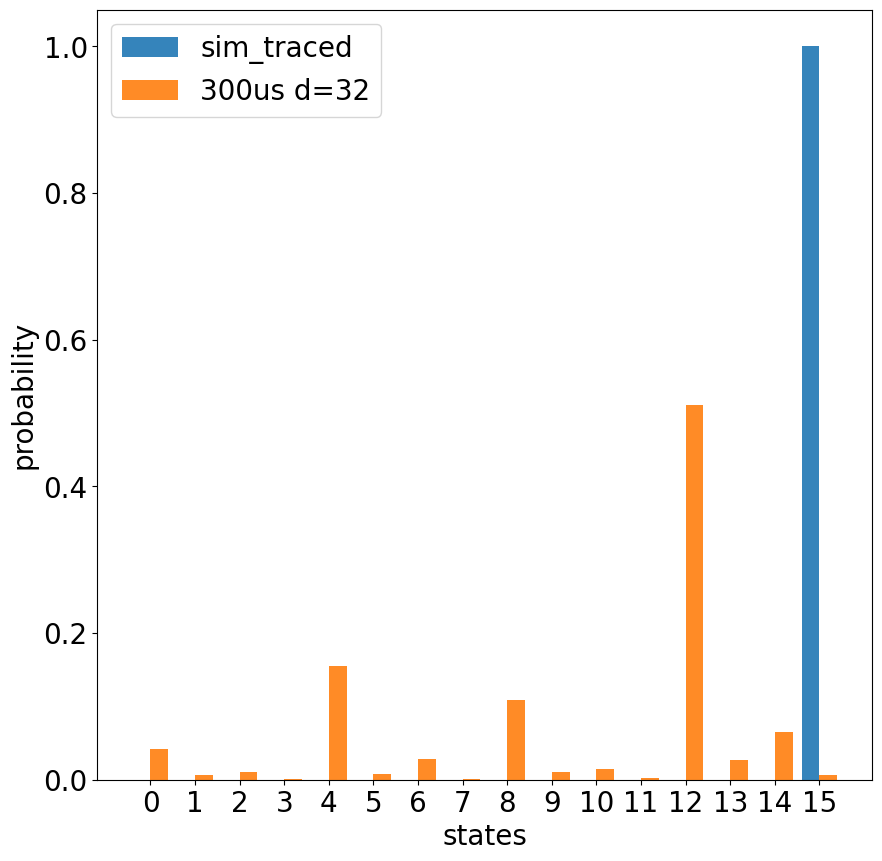

2024-02-06-192307_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:F

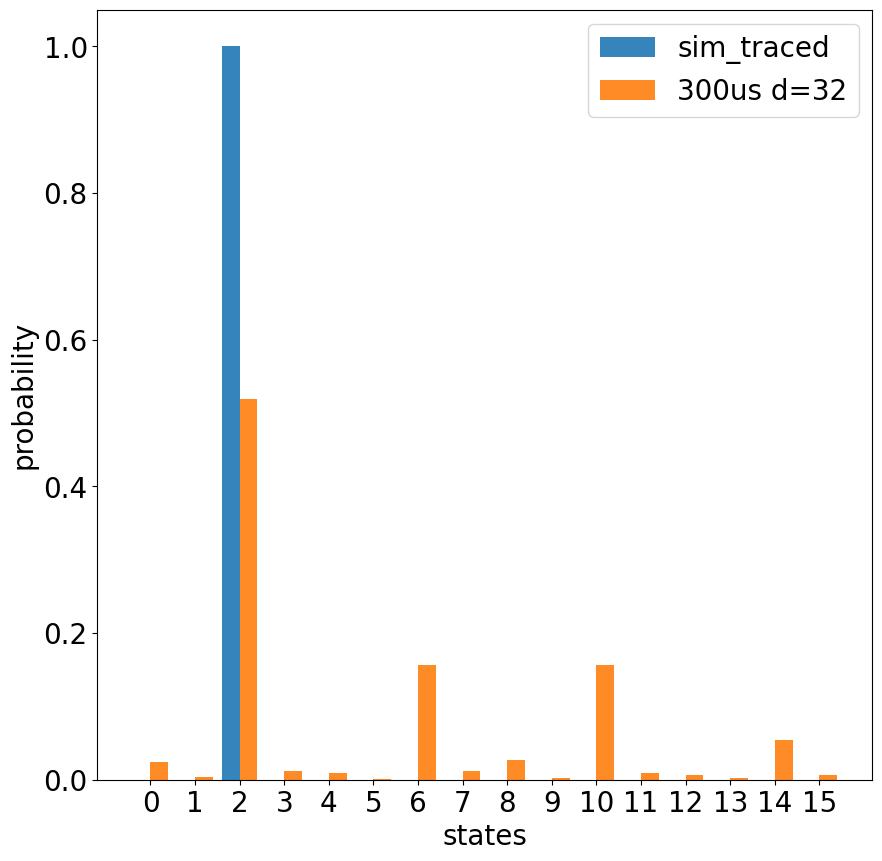

2024-02-06-192524_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52

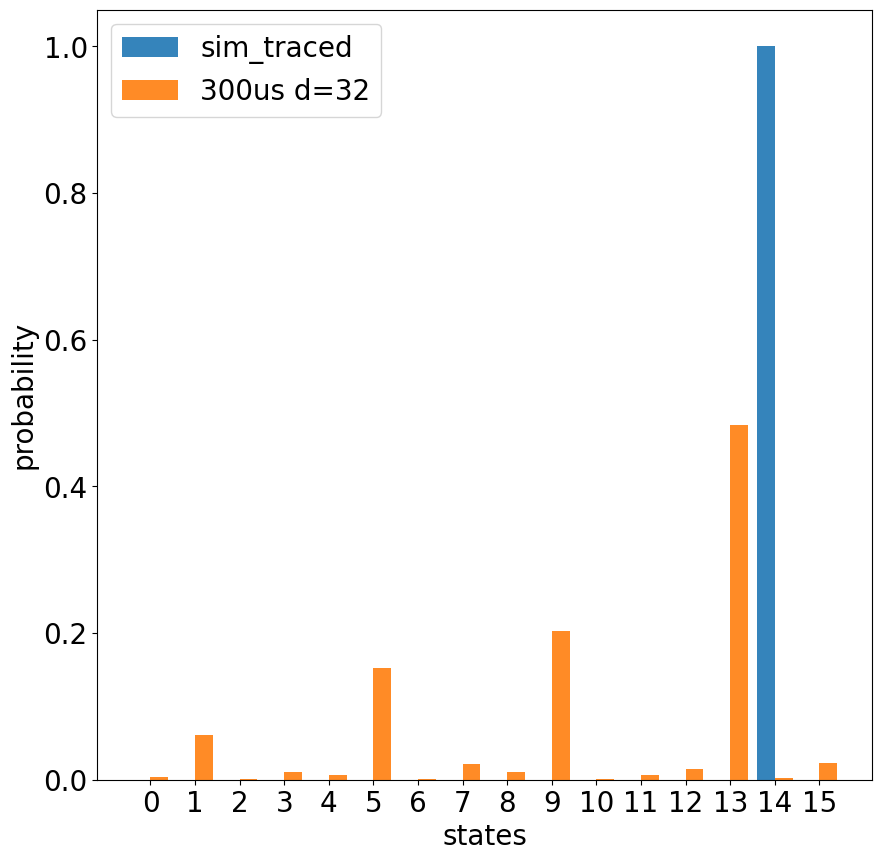

2024-02-06-192704_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+22:FTXA25

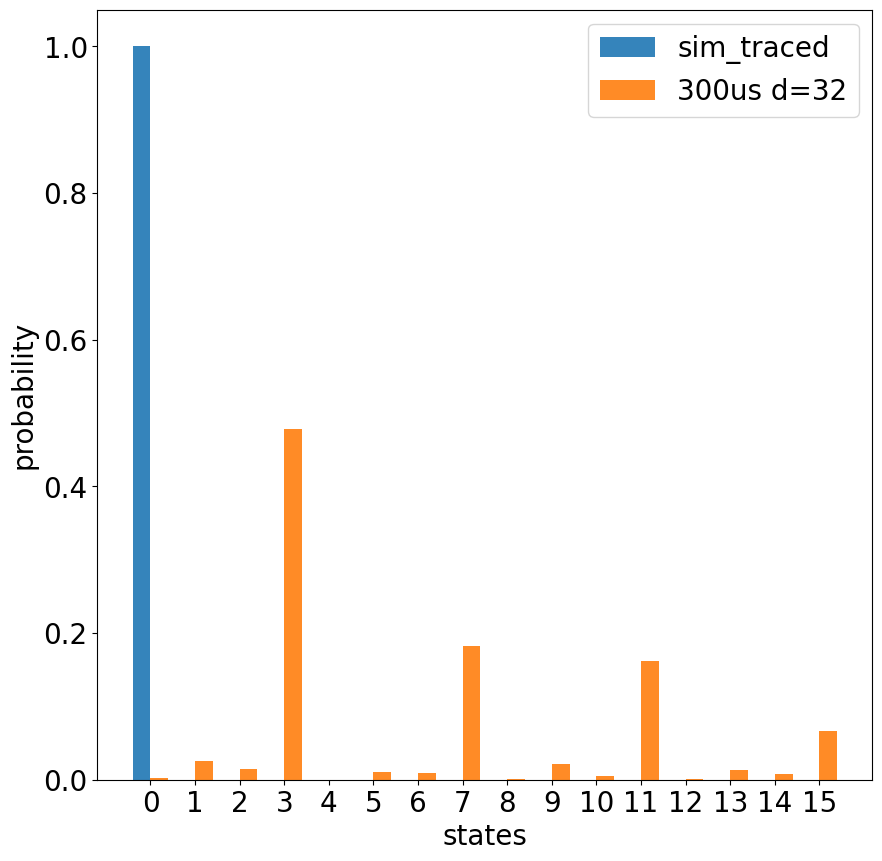

2024-02-06-194004_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-

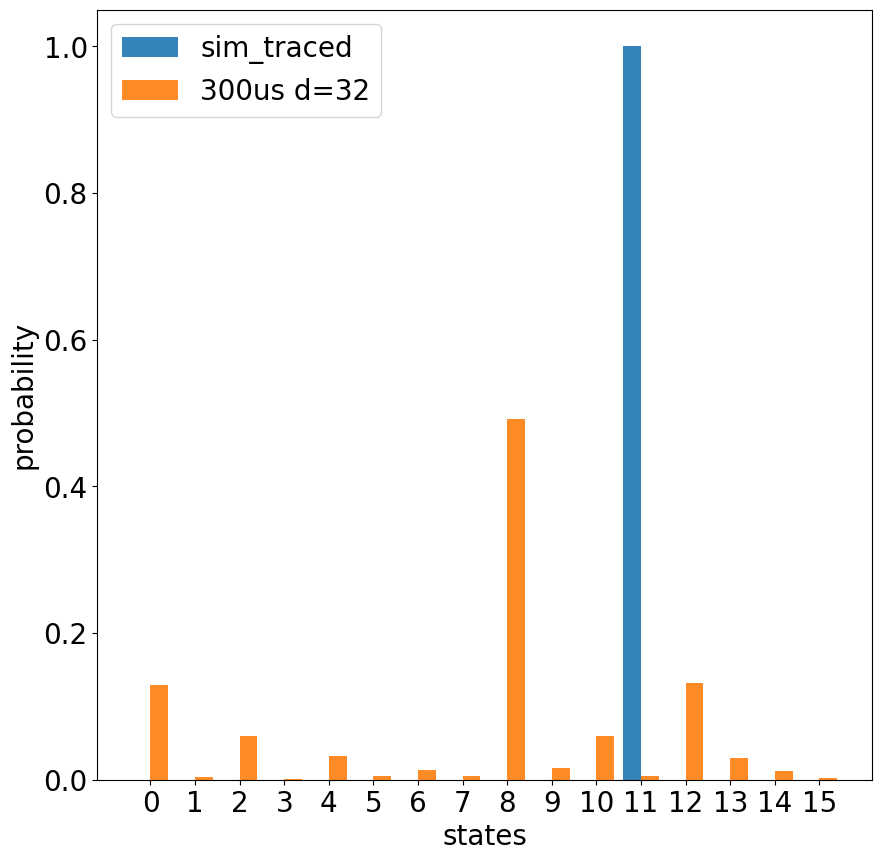

2024-02-06-194145_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+31:RY+22

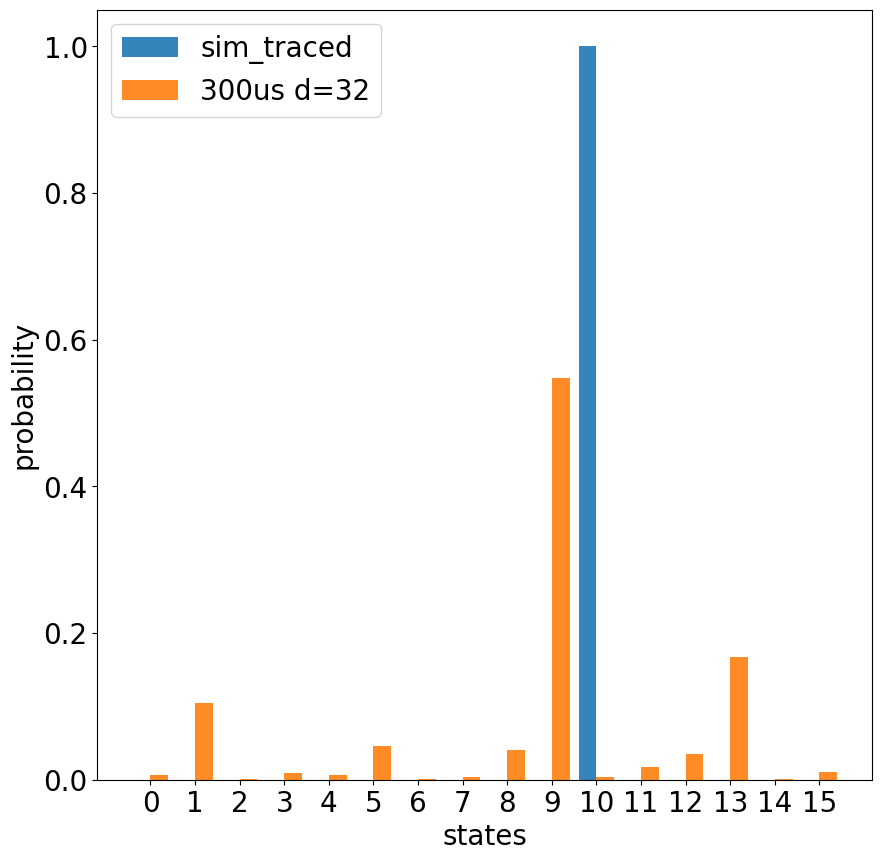

2024-02-06-194323_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FT

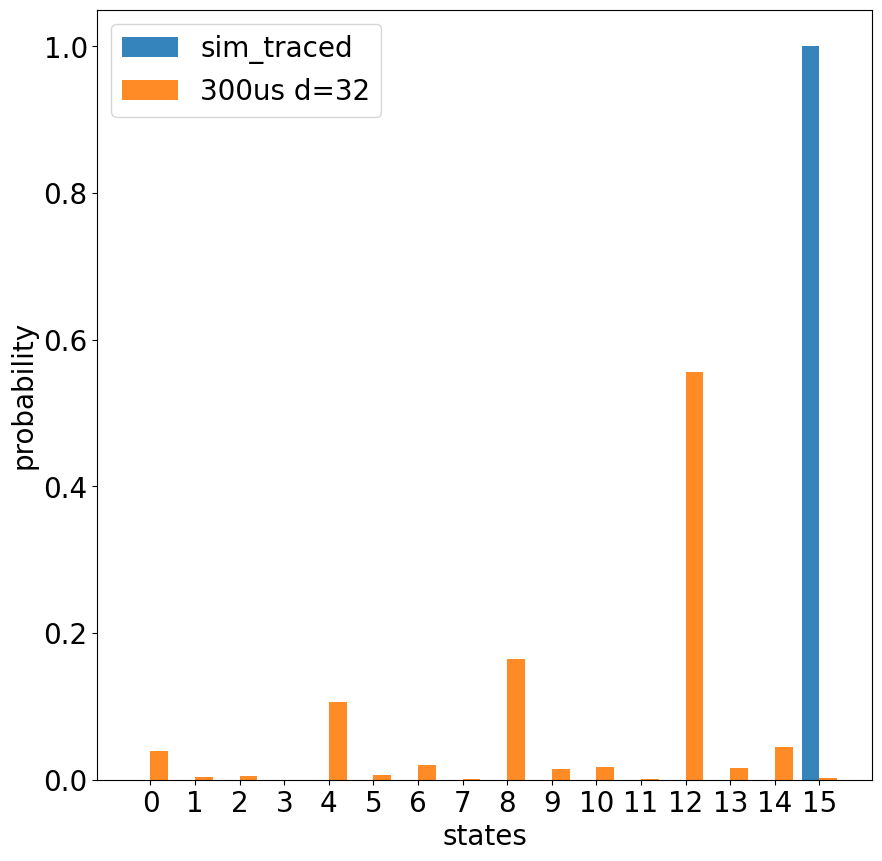

2024-02-06-194503_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ3+1.0000:RY+22

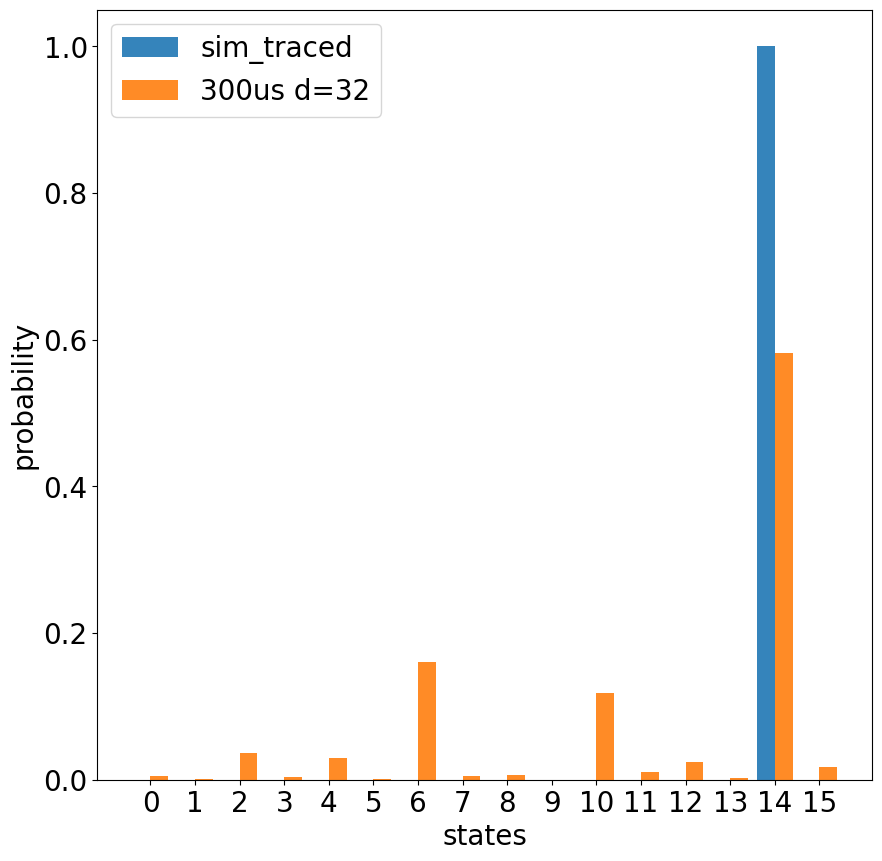

2024-02-06-194723_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:FTXA230.2500+:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2

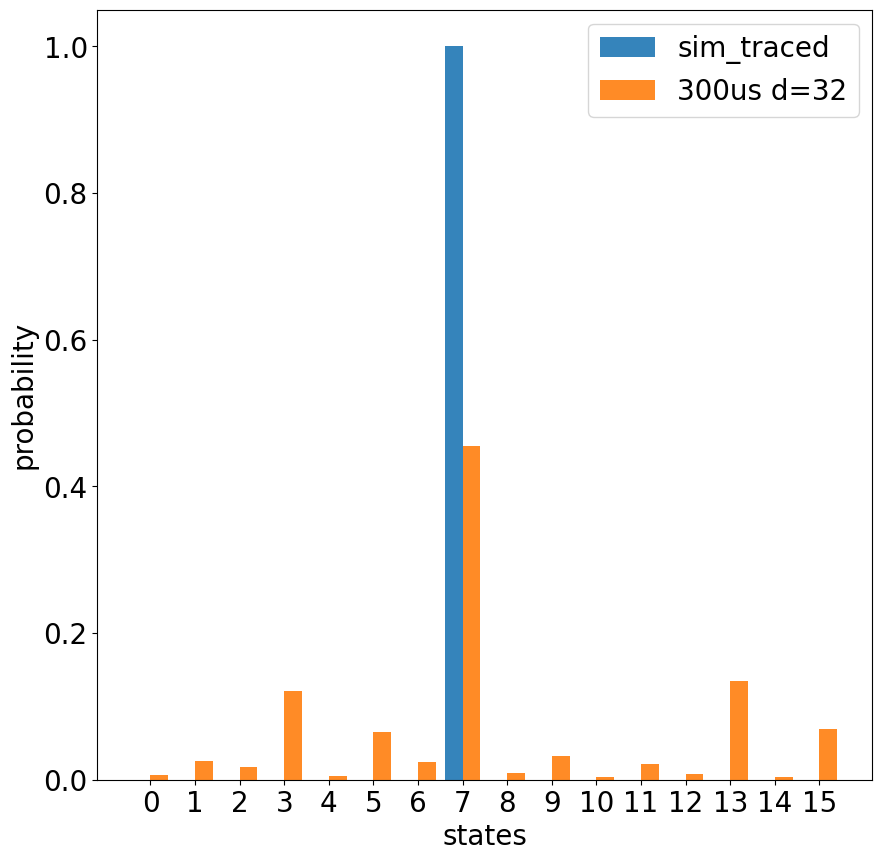

2024-02-06-194900_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:FTXA230.2500+:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-4

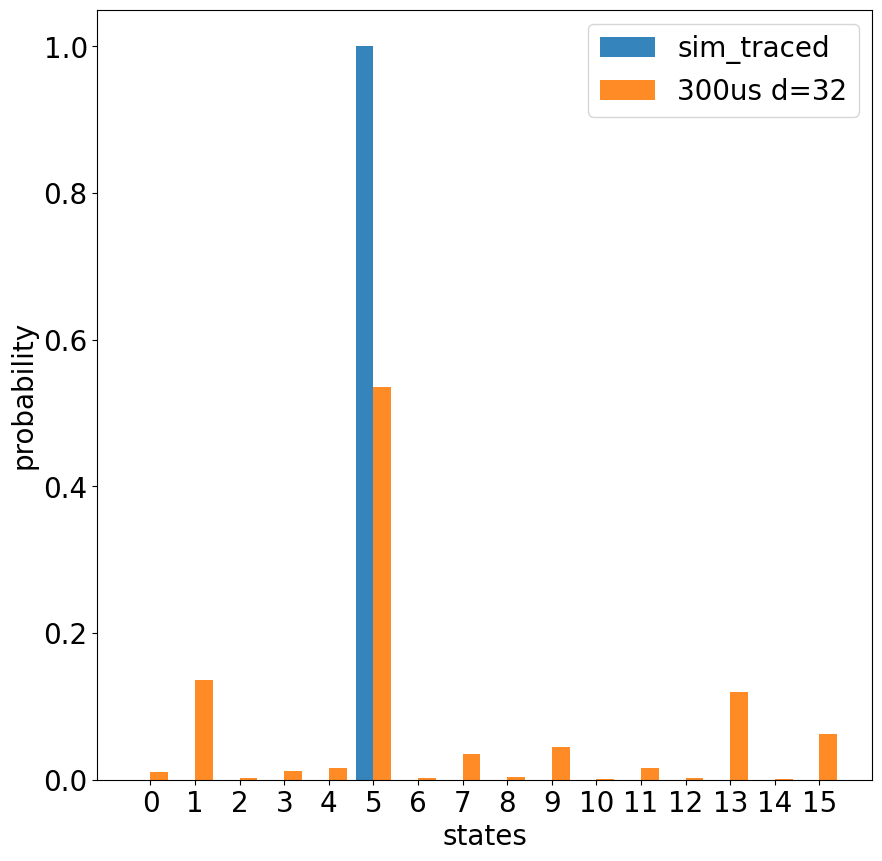

2024-02-06-195040_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:RY+22:FTXA250.2500+:RY-22:RX

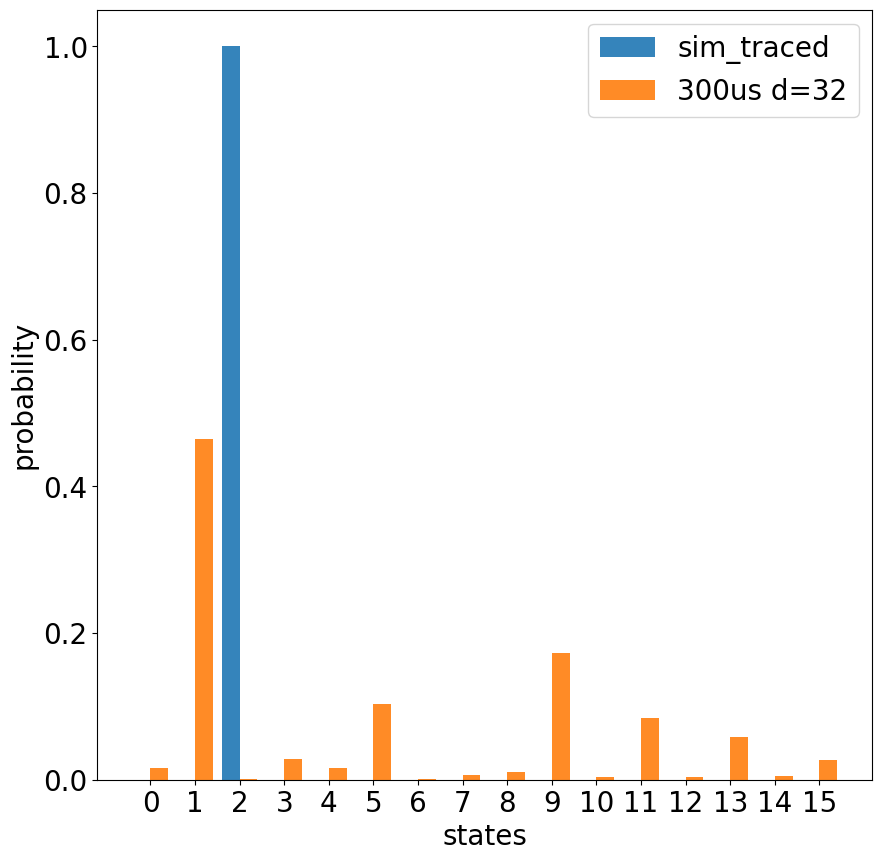

2024-02-06-195219_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:RY

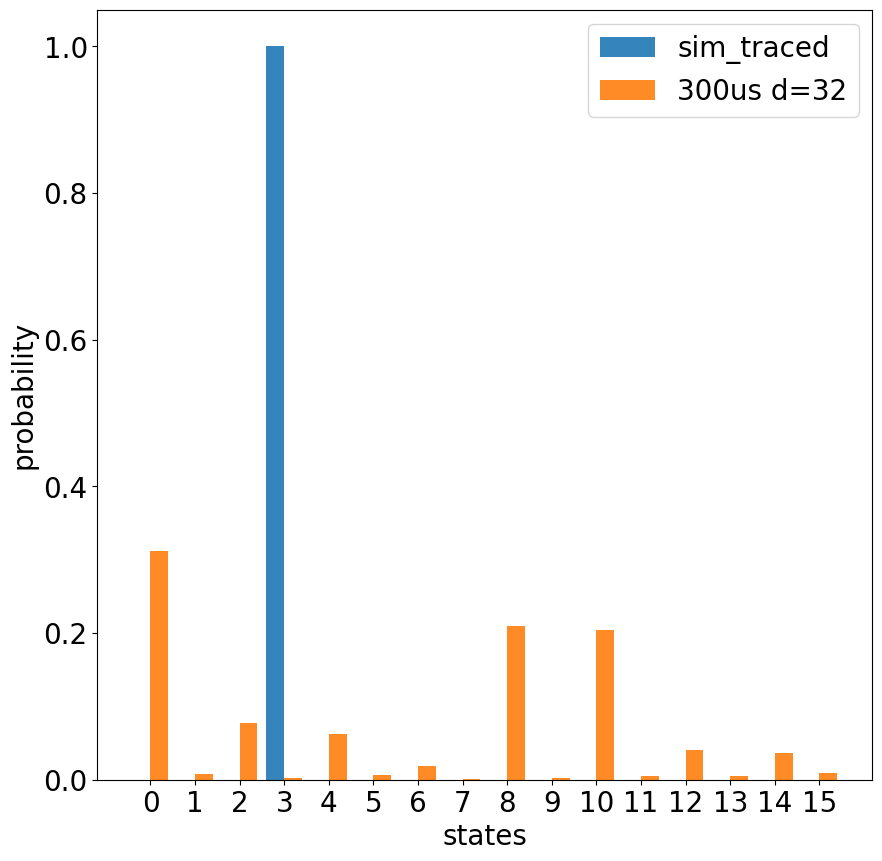

2024-02-06-195438_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:FTXA230.2500+:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:RY+22:

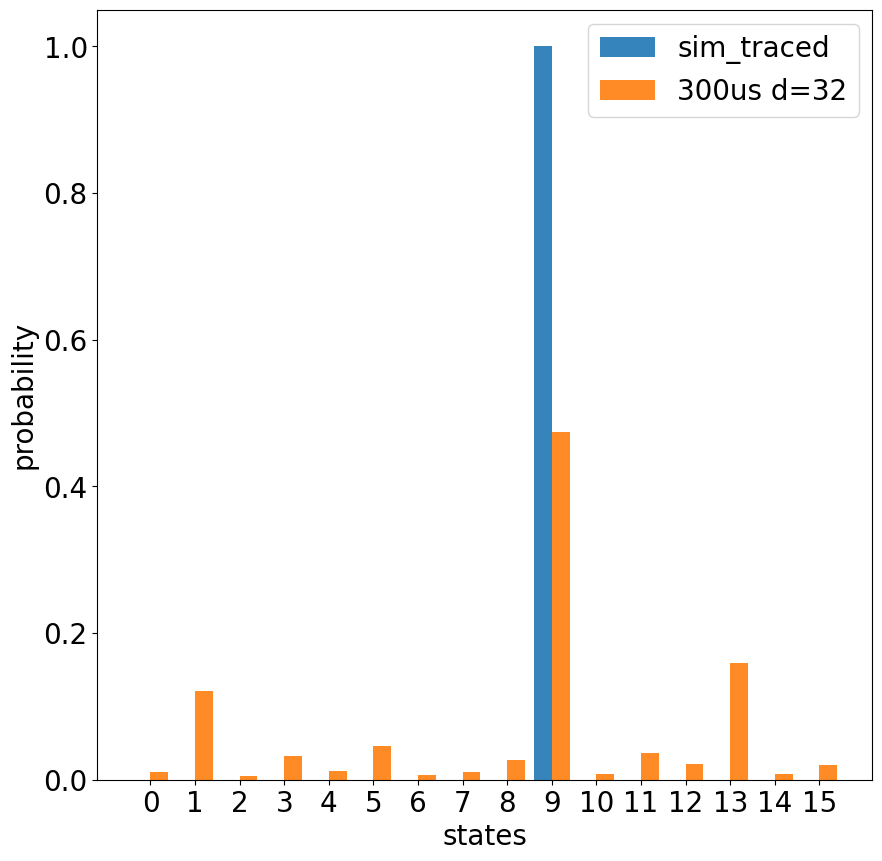

2024-02-06-195619_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA

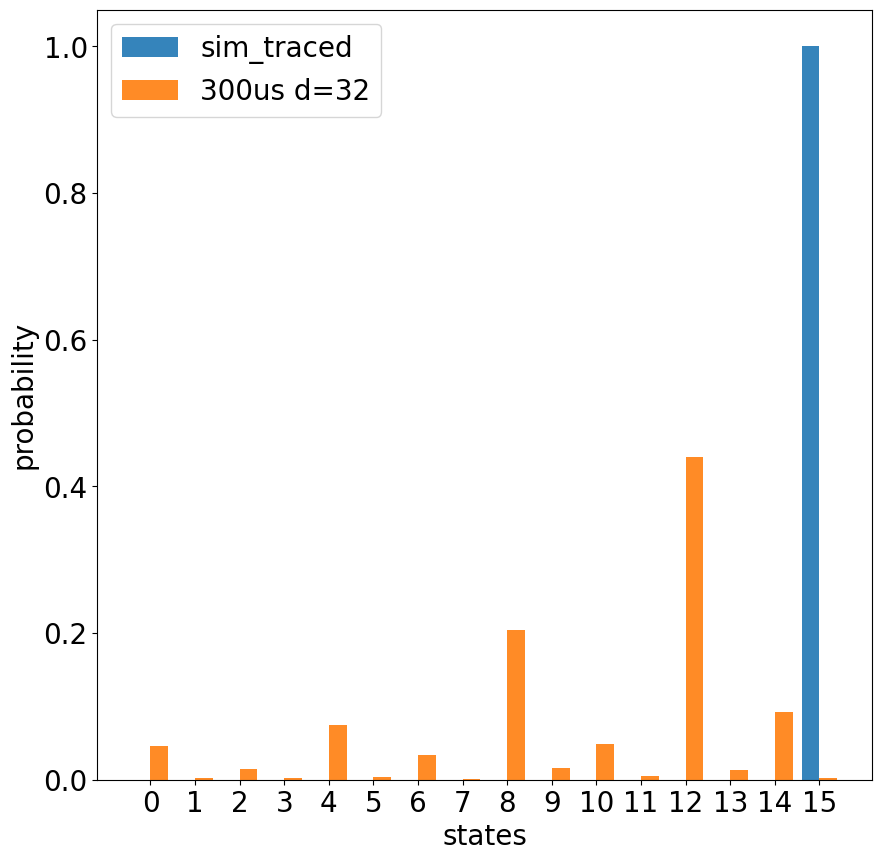

2024-02-06-195802_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:FTXA230.2500+:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2

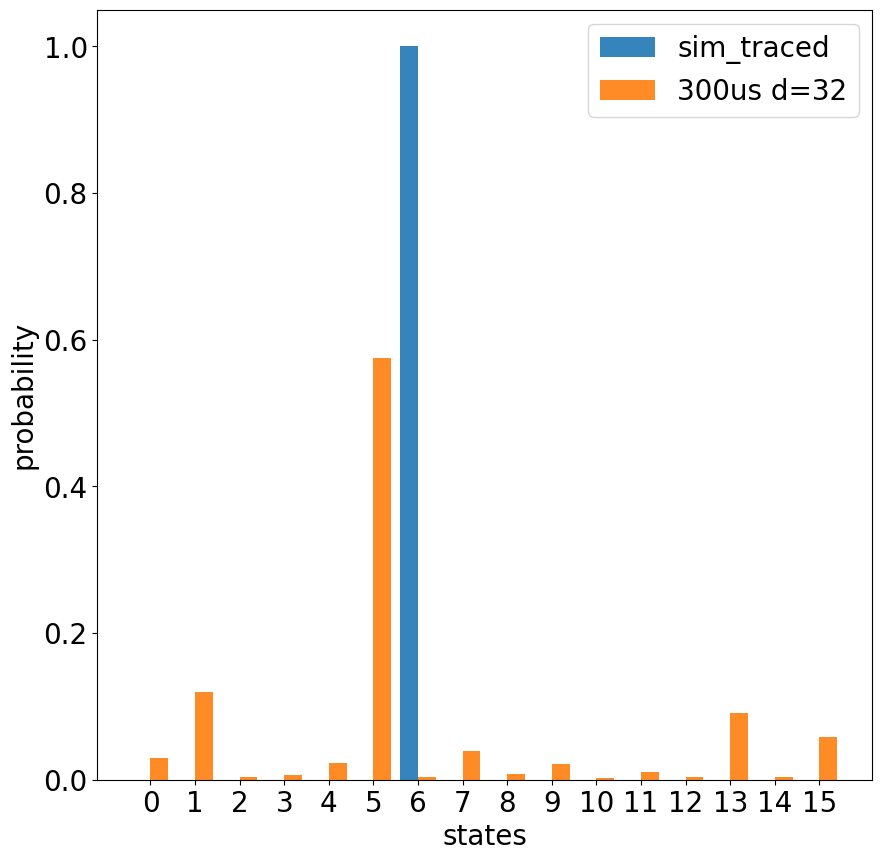

2024-02-06-195941_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-

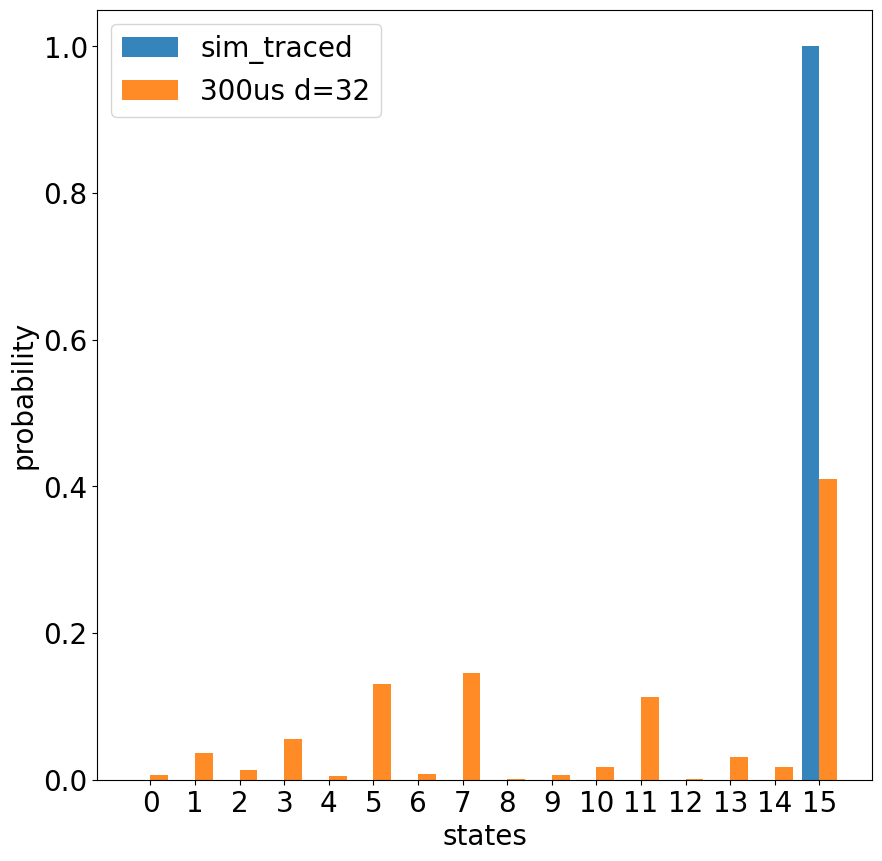

2024-02-06-200203_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+31:RY+22:FTXA

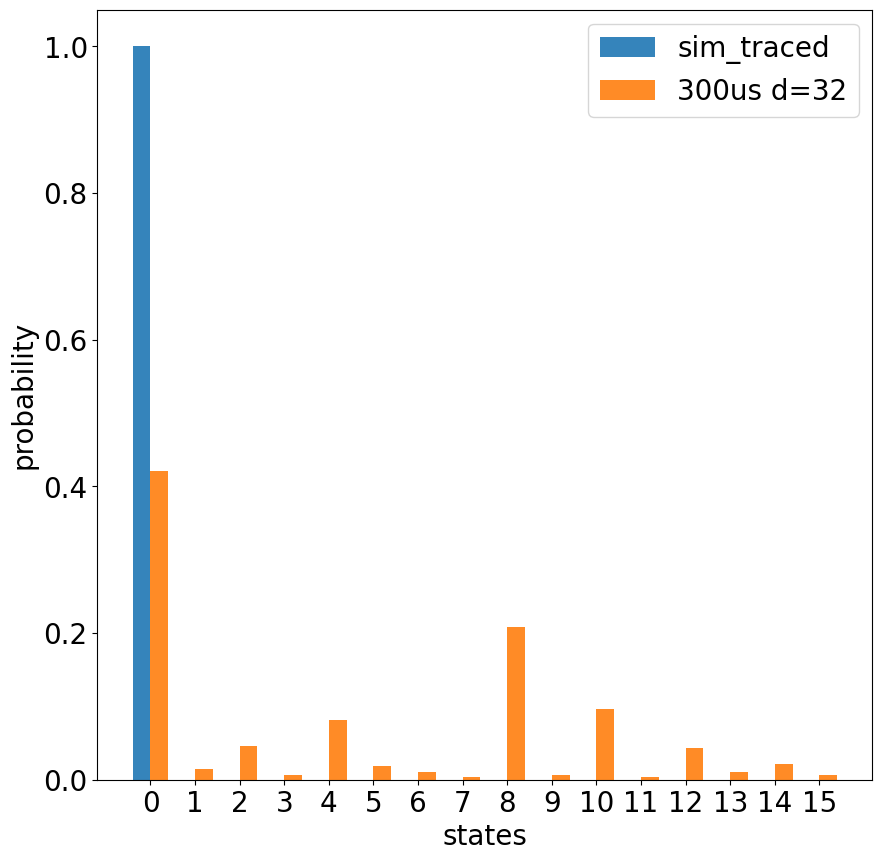

2024-02-06-201533_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



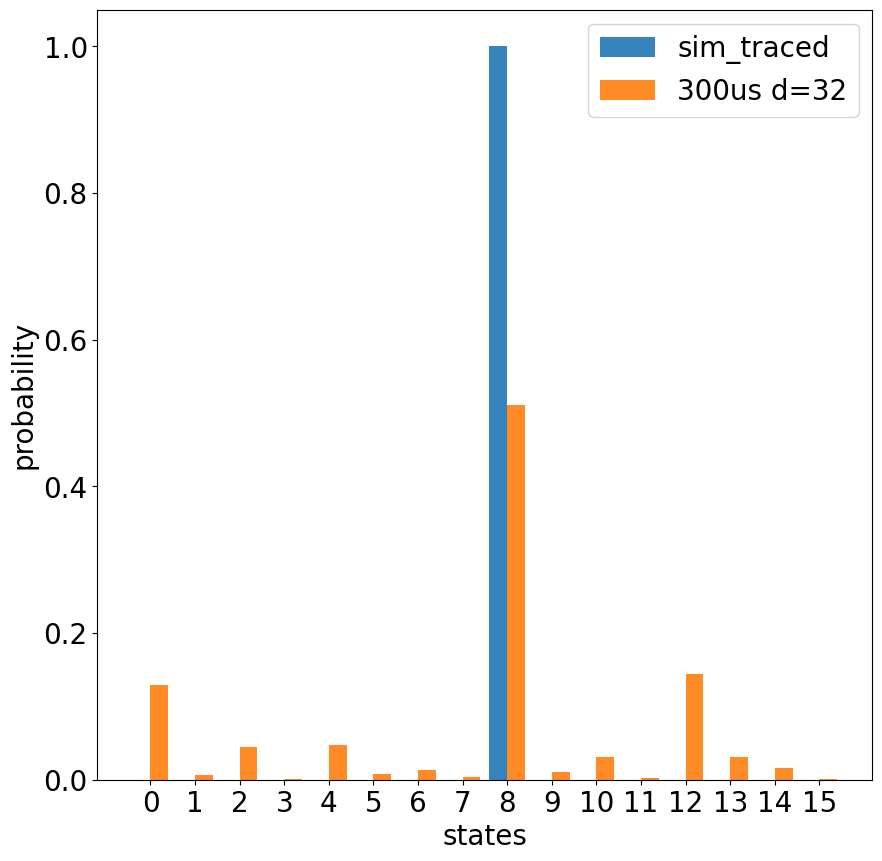

In [47]:
filenames_data=[]
counts_d32=[]
counts_d32_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d32.copy()
print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d32
circuit=c_d32
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d32.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","300us d=32"])

In [48]:
# print (counts_d2[0])
# print (counts_d2_spam[0])

In [49]:
import copy
from copy import copy, deepcopy
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/02062024 EAB_FT_01+10_23541/c11f6f1a-7a1a-4af1-b587-cb078b63752eXX23541_FT_01+10", "rb") as fp:   # Unpickling
    eab_load = pickle.load(fp)

eab_load_cpy=deepcopy(eab_load[0:100])
eab_load_cpy_spam=deepcopy(eab_load[0:100])

In [50]:
C=20
for i in range (C):
#     print (i)
    assert eab_load_cpy[i]["L"]==2
    # print (eab_load_cpy[i]["counts"])
    # print (counts_d2_sim[i])

    # print (counts_d2[i].copy())
    # print ("\n")
    eab_load_cpy[i]["counts"]=counts_d2[i].copy()


    
# for i in range (C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==2
#     eab_load_cpy_spam[i]["counts"]=counts_d2_spam[i].copy()



# for i in range (C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])

In [51]:
# for i in range (C,2*C):
# #     print (i)
#     assert eab_load_cpy[i]["L"]==4
#     eab_load_cpy[i]["counts"]=counts_d4[i-C].copy()


In [52]:
for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==8
    eab_load_cpy[i]["counts"]=counts_d8[i-2*C].copy()


In [53]:
# print (eab_load_cpy)

In [54]:
# for i in range (3*C,4*C):
# #     print (i)
#     assert eab_load_cpy[i]["L"]==16
#     eab_load_cpy[i]["counts"]=counts_d16[i-3*C].copy()
# #     print ( eab_load_cpy[i]["counts_exp"])
# #     print (eab_load_cpy[i])

for i in range (4*C,5*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==32
    eab_load_cpy[i]["counts"]=counts_d32[i-4*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

In [55]:
filename = str(uuid.uuid4())
filename+="XX23541_300us_wait_FT_01+10_02062024_ExperimentalData"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/scan wait time test/300us/"+filename, "wb") as fp:
    pickle.dump(eab_load_cpy, fp)


In [56]:
print ("done")

done


Data analysis

plot average fidelity and fit

plot fidelity from each circuit and fit

data analysis with bootstrapping

spam results

In [ ]:

b=[]
c=[1,2]
f=c
c=[1]
print (d)
print (b)
print (c)